In [204]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from scipy.stats import f_oneway
from IPython.display import display

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import seaborn as sns

In [205]:
OpenFoodProducts = pd.read_csv("fr-openfoodfacts-org-products.csv", sep='\t', low_memory=False)

Ceci est un résumé de notre base de données produit : 
rangeIndex correspond au nombre de produits disponibles
Columns correspondra aux différentes informations qu'on va avoir pour chaque produit, 
et dType au format de l'information : Ici on aura principalement des informations quantitatives et des informations catégorielles

In [206]:
OpenFoodProducts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(106), object(56)
memory usage: 396.5+ MB


Dans le contexte de notre étude, nous allons principalement travaillé sur les valeurs nutritionnelles. 

In [207]:
OpenFoodProducts_nutrition_facts = OpenFoodProducts[['energy_100g',
 'energy-from-fat_100g',
 'fat_100g',
 'saturated-fat_100g',
 'butyric-acid_100g',
 'caproic-acid_100g',
 'caprylic-acid_100g',
 'capric-acid_100g',
 'lauric-acid_100g',
 'myristic-acid_100g',
 'palmitic-acid_100g',
 'stearic-acid_100g',
 'arachidic-acid_100g',
 'behenic-acid_100g',
 'lignoceric-acid_100g',
 'cerotic-acid_100g',
 'montanic-acid_100g',
 'melissic-acid_100g',
 'monounsaturated-fat_100g',
 'polyunsaturated-fat_100g',
 'omega-3-fat_100g',
 'alpha-linolenic-acid_100g',
 'eicosapentaenoic-acid_100g',
 'docosahexaenoic-acid_100g',
 'omega-6-fat_100g',
 'linoleic-acid_100g',
 'arachidonic-acid_100g',
 'gamma-linolenic-acid_100g',
 'dihomo-gamma-linolenic-acid_100g',
 'omega-9-fat_100g',
 'oleic-acid_100g',
 'elaidic-acid_100g',
 'gondoic-acid_100g',
 'mead-acid_100g',
 'erucic-acid_100g',
 'nervonic-acid_100g',
 'trans-fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'sucrose_100g',
 'glucose_100g',
 'fructose_100g',
 'lactose_100g',
 'maltose_100g',
 'maltodextrins_100g',
 'starch_100g',
 'polyols_100g',
 'fiber_100g',
 'proteins_100g',
 'casein_100g',
 'serum-proteins_100g',
 'nucleotides_100g',
 'salt_100g',
 'sodium_100g',
 'alcohol_100g',
 'vitamin-a_100g',
 'beta-carotene_100g',
 'vitamin-d_100g',
 'vitamin-e_100g',
 'vitamin-k_100g',
 'vitamin-c_100g',
 'vitamin-b1_100g',
 'vitamin-b2_100g',
 'vitamin-pp_100g',
 'vitamin-b6_100g',
 'vitamin-b9_100g',
 'folates_100g',
 'vitamin-b12_100g',
 'biotin_100g',
 'pantothenic-acid_100g',
 'silica_100g',
 'bicarbonate_100g',
 'potassium_100g',
 'chloride_100g',
 'calcium_100g',
 'phosphorus_100g',
 'iron_100g',
 'magnesium_100g',
 'zinc_100g',
 'copper_100g',
 'manganese_100g',
 'fluoride_100g',
 'selenium_100g',
 'chromium_100g',
 'molybdenum_100g',
 'iodine_100g',
 'caffeine_100g',
 'taurine_100g',
 'ph_100g',
 'fruits-vegetables-nuts_100g',
 'collagen-meat-protein-ratio_100g',
 'cocoa_100g',
 'chlorophyl_100g',
 'carbon-footprint_100g',
 'nutrition-score-fr_100g',
 'nutrition-score-uk_100g']]

In [208]:
OpenFoodProducts_nutrition_facts_percentage = OpenFoodProducts_nutrition_facts.drop(columns=["fruits-vegetables-nuts_100g"]).isnull().mean()

In [209]:
columns_to_drop = OpenFoodProducts_nutrition_facts_percentage[OpenFoodProducts_nutrition_facts_percentage > 0.9].index.tolist()

In [210]:
OpenFoodProducts_nutrition_facts = OpenFoodProducts_nutrition_facts.drop(columns=columns_to_drop)

Sur cette base de données, j'ai décidé de garder uniquement les informations nutritionnelles dont nous manquons cette information sur plus de 90% de produits. 
Une exception a été faire pour la valeur fruits-vegetables-nuts_100g qui est une information importante pour le calcul du nutriscore

Ensuite, je vous propose cette matrice de corrélation entre les différentes valeurs restantes

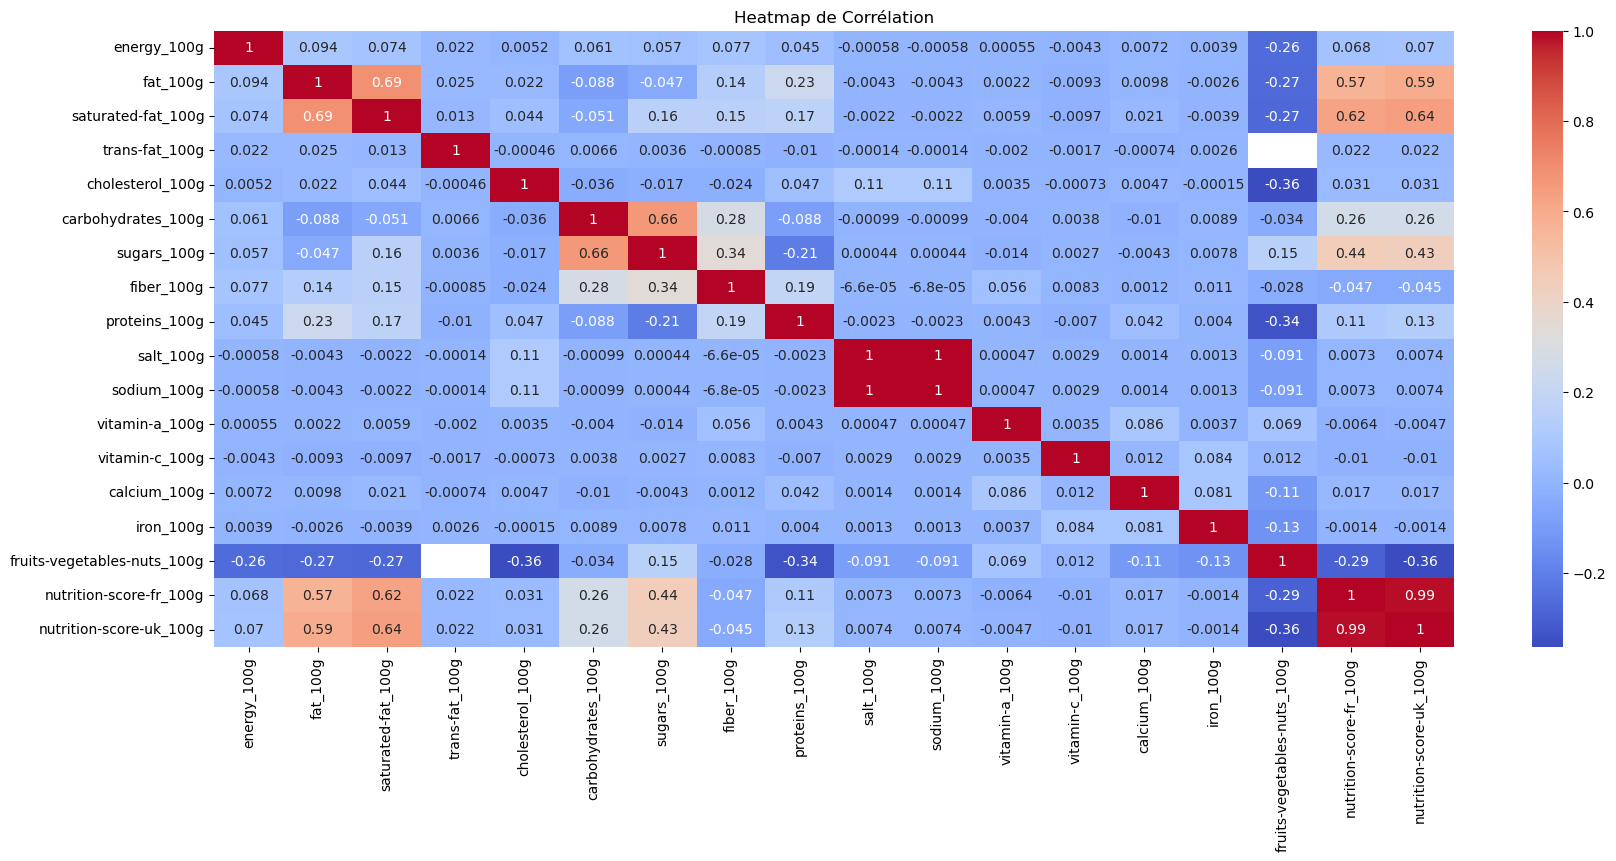

In [211]:
# Calculer la matrice de corrélation
correlation_matrix = OpenFoodProducts_nutrition_facts.corr()

# Créer la heatmap de corrélation
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix,annot=True, cmap='coolwarm')
plt.title("Heatmap de Corrélation")
plt.show()

On voit que certaines valeurs nutritionnelles sont corrélées, et donc on pourrait s'imaginer d'en garder qu'un seul. 
De même, certaines valeurs sont corrélées à 1, ce qui signifie que les deux valeurs se comportent exactement de la même façon. 
Dans le cadre de notre analyse, on va se concentrer particulièrement sur les données relatives au nutriscore FR. Selon le site : https://quoidansmonassiette.fr/comment-est-calcule-le-nutri-score-logo-nutritionnel/ , le nutriscore est calculé à partir des données suivantes : 
- Energie : 'energy_100g'
- les acides gras saturés (g/100g) : 'saturated-fat_100g'
- les sucres simples (g/100g) : 'sugars_100g'
- le sel (mg/100g) : 'sodium_100g' ou 'salt_100g', mais on prendre le salt car il y a le pourcentage de remplissage de sel > que celui du sodiul
- les fibres (g/100g) : 'fiber_100g'
- les protéines (g/100g) : 'proteins_100g' 
- les fruits et légumes : 'fruits-vegetables-nuts_100g'
- légumineuses et fruits à coque (g/100g) : 'fruits-vegetables-nuts_100g'
Donc on réduira le tableau à ces principales données + 'nutrition-score-fr_100g'

In [212]:
OpenFoodProducts_nutrition_facts_kept = ['energy_100g','saturated-fat_100g','sugars_100g','salt_100g','fiber_100g','proteins_100g','fruits-vegetables-nuts_100g','nutrition-score-fr_100g'] 
OpenFoodProducts_nutrition_facts=OpenFoodProducts_nutrition_facts[OpenFoodProducts_nutrition_facts_kept]

# Analyse univariée des différentes valeurs. 

On va commencer par analyser les différentes valeurs que prend chaque valeurs nutritionnelles. Le but de cette exercice est surtout de pouvoir identifier rapidement les valeurs aberrantes qu'on décidera par la suite de supprimer.

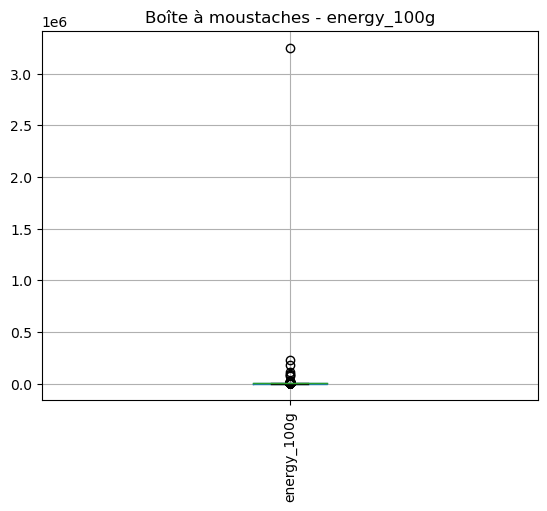

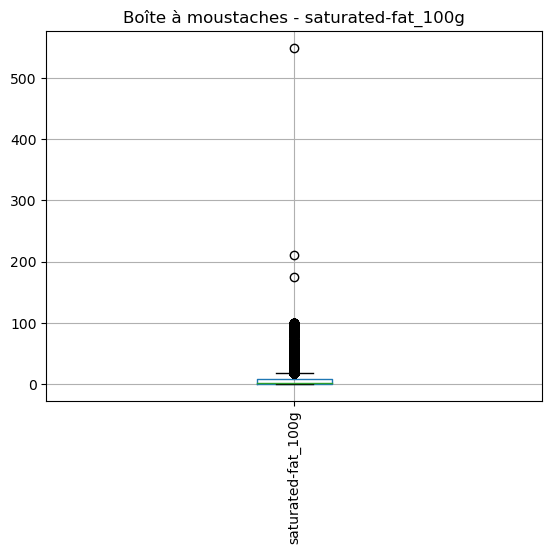

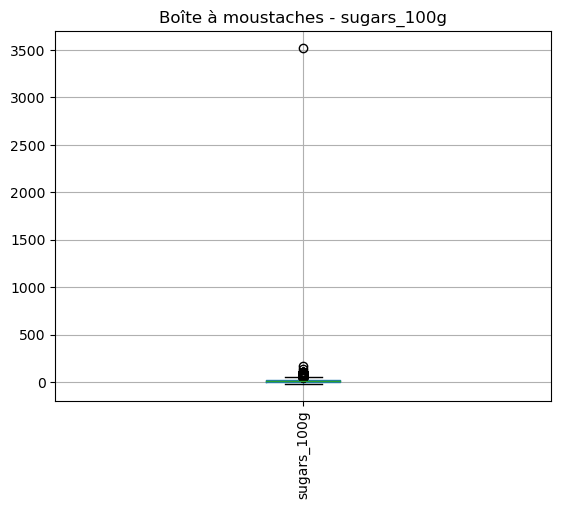

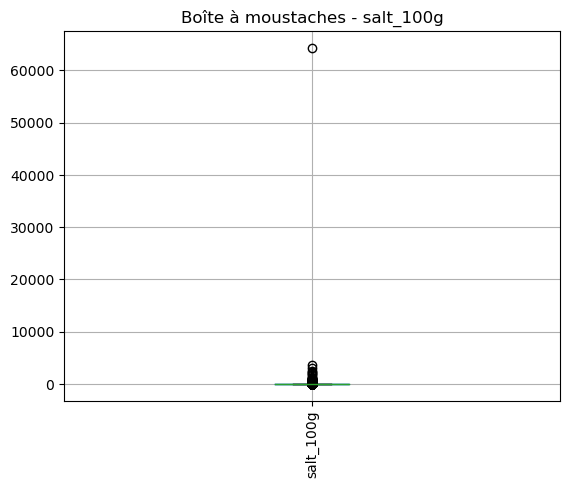

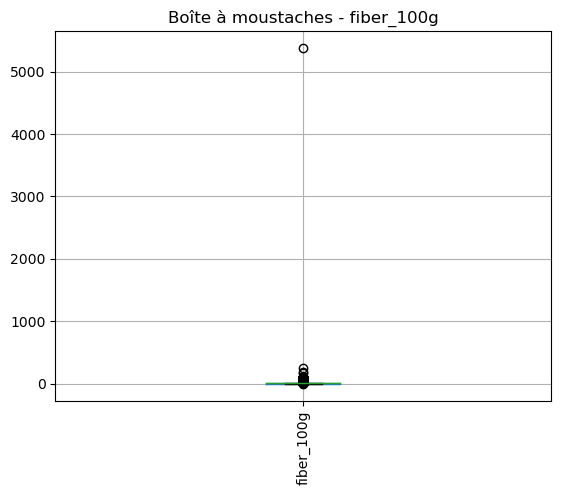

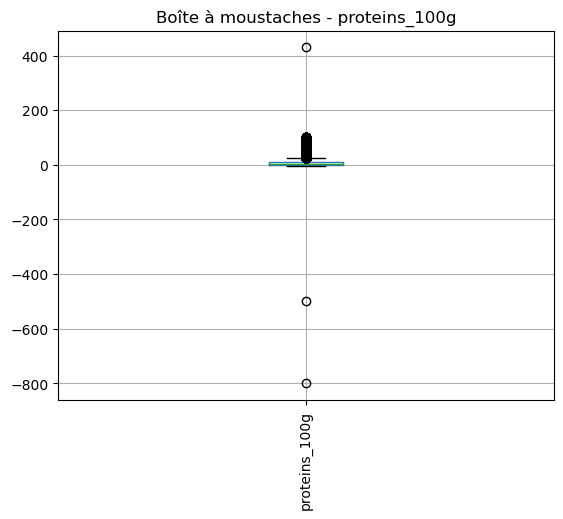

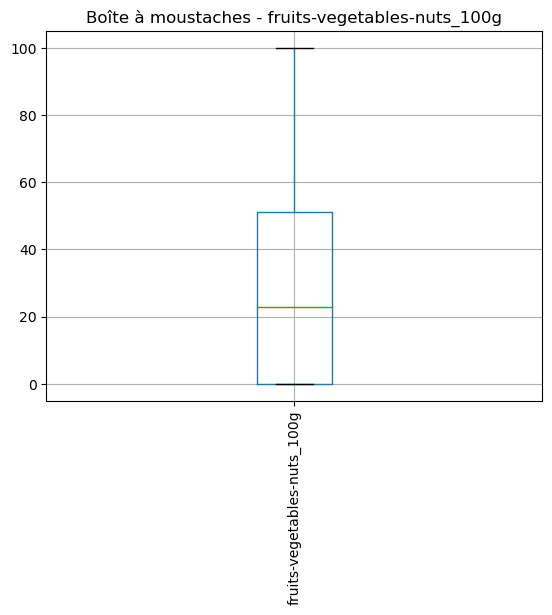

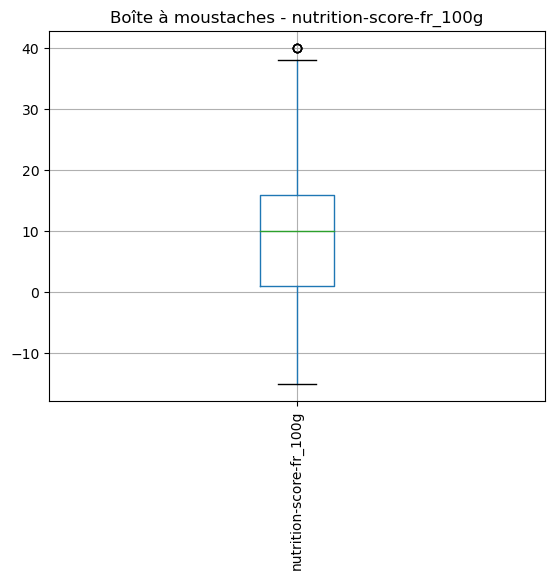

In [213]:
# Boucle pour parcourir chaque colonne du dataframe
for i in OpenFoodProducts_nutrition_facts.columns:
    # Vérifiez le type pour chaque colonne
    if pd.api.types.is_numeric_dtype(OpenFoodProducts_nutrition_facts[i]):
        # Si la colonne est de type numérique, je souhaiterai générer une boite à moustache
        OpenFoodProducts_nutrition_facts.boxplot(column=i)
        plt.xticks(rotation='vertical') 
        plt.title(f"Boîte à moustaches - {i}")
        plt.show()
    else:
        # Sinon générer un graphe en barres, et n'afficher que les 10 valeurs les plus récurrentes
        Valeurs = OpenFoodProducts_nutrition_facts[i].value_counts().nlargest(30)
        Autres = OpenFoodProducts_nutrition_facts[i].value_counts().nsmallest(len(OpenFoodProducts_short[i].unique()) - 10).sum()
        plt.xticks(rotation='vertical') 
        plt.bar(Valeurs.index, Valeurs.values)
        plt.title(f"Graphique à barres - {i}")
        
        if Autres > 0:
            plt.bar("Autres", Autres)
        
        plt.show()


In [214]:
OpenFoodProducts_nutrition_facts.describe()

energy_100g  saturated-fat_100g    sugars_100g      salt_100g  \
count  2.611130e+05       229554.000000  244971.000000  255510.000000   
mean   1.141915e+03            5.129932      16.003484       2.028624   
std    6.447154e+03            8.014238      22.327284     128.269454   
min    0.000000e+00            0.000000     -17.860000       0.000000   
25%    3.770000e+02            0.000000       1.300000       0.063500   
50%    1.100000e+03            1.790000       5.710000       0.581660   
75%    1.674000e+03            7.140000      24.000000       1.374140   
max    3.251373e+06          550.000000    3520.000000   64312.800000   

          fiber_100g  proteins_100g  fruits-vegetables-nuts_100g  \
count  200886.000000  259922.000000                  3036.000000   
mean        2.862111       7.075940                    31.458587   
std        12.867578       8.409054                    31.967918   
min        -6.700000    -800.000000                     0.000000   
25%         0.000000       0.700000                     0.000000   
50%         1.500000       4.760000                    23.000000   
75%         3.600000      10.000000                    51.000000   
max      5380.000000     430.000000                   100.000000   

       nutrition-score-fr_100g  
count            221210.000000  
mean                  9.165535  
std                   9.055903  
min                 -15.000000  
25%                   1.000000  
50%                  10.000000  
75%                  16.000000  
max                  40.000000

On remarquera que nous allons avoir des valeurs d'énergie supérieures aux maximum connu dans la littérature (>3700kj), et des valeurs supérieures à 100g pour les différents nutriments sur un échantillon de 100g et on supprimera la ligne qui ont que des valeurs nulles. Cela nous donne un récap de notre dataframe comme le suivant :

In [215]:
OpenFoodProducts_details=OpenFoodProducts_nutrition_facts

In [216]:
# Remplacer toutes les valeurs énergetiques supérieures à 3700
OpenFoodProducts_details.loc[OpenFoodProducts_details['energy_100g'] >= 3700, 'energy_100g'] = np.nan

In [217]:
colonnes_numeriques_wo_energy_nutri = ['saturated-fat_100g', 'sugars_100g','salt_100g','fiber_100g','proteins_100g','fruits-vegetables-nuts_100g']

In [218]:
# Remplacement des valeurs supérieures à 100 dans les autres colonnes numériques
OpenFoodProducts_details.loc[:, colonnes_numeriques_wo_energy_nutri] = OpenFoodProducts_details.loc[:, colonnes_numeriques_wo_energy_nutri].where(OpenFoodProducts_details.loc[:, colonnes_numeriques_wo_energy_nutri] <= 100, np.nan)

In [219]:
# Remplacement des valeurs inférieures à 0 dans les autres colonnes numériques
OpenFoodProducts_details.loc[:, colonnes_numeriques_wo_energy_nutri] = OpenFoodProducts_details.loc[:, colonnes_numeriques_wo_energy_nutri].where(OpenFoodProducts_details.loc[:, colonnes_numeriques_wo_energy_nutri]>0, np.nan)

In [220]:
# Suppression des lignes dont toutes les valeurs sont nulles. 
OpenFoodProducts_details= OpenFoodProducts_details.dropna(how='all')

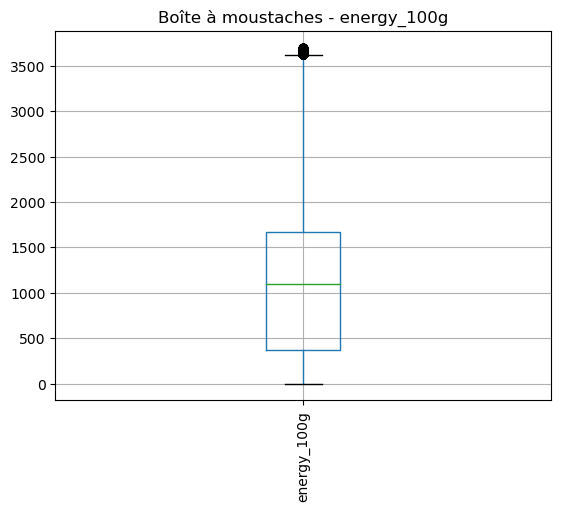

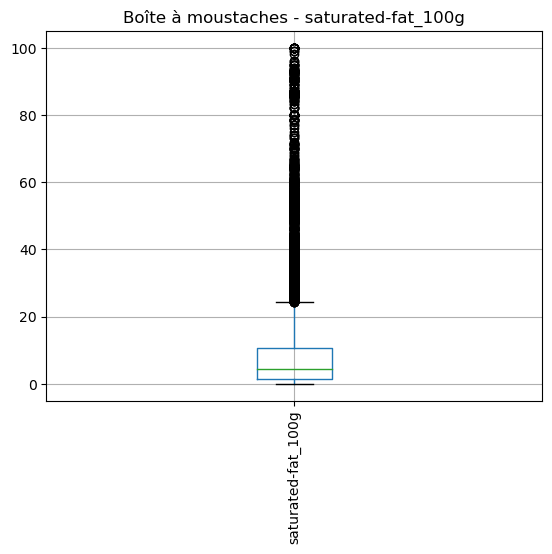

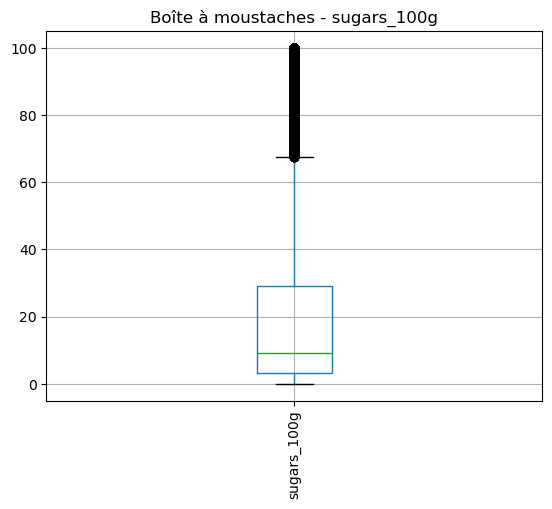

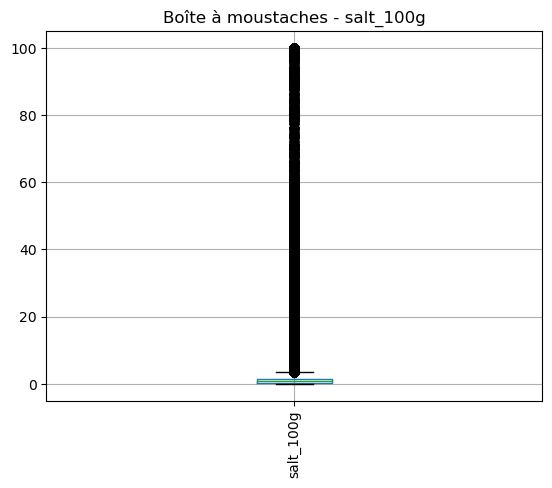

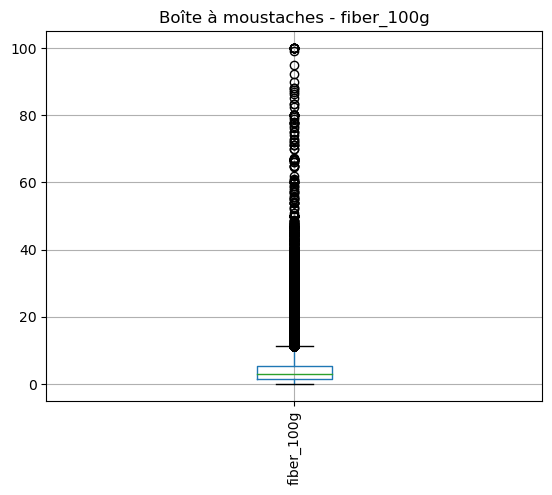

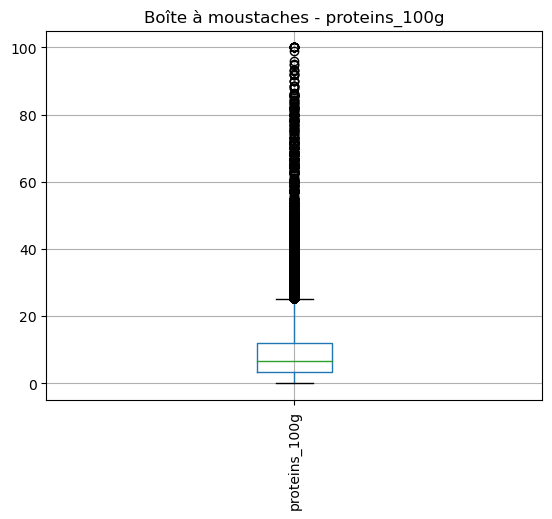

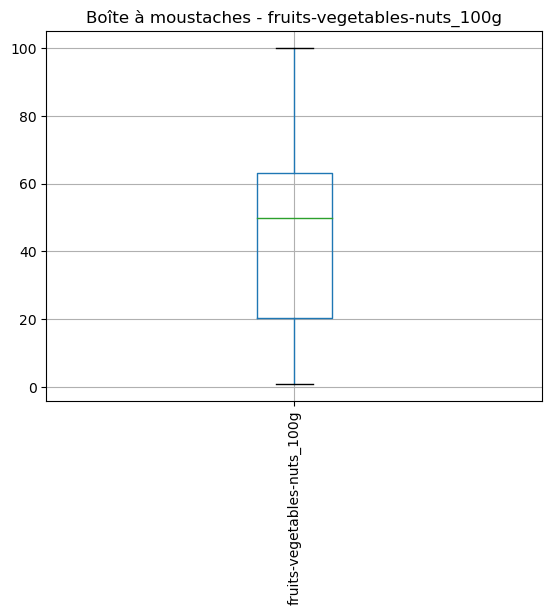

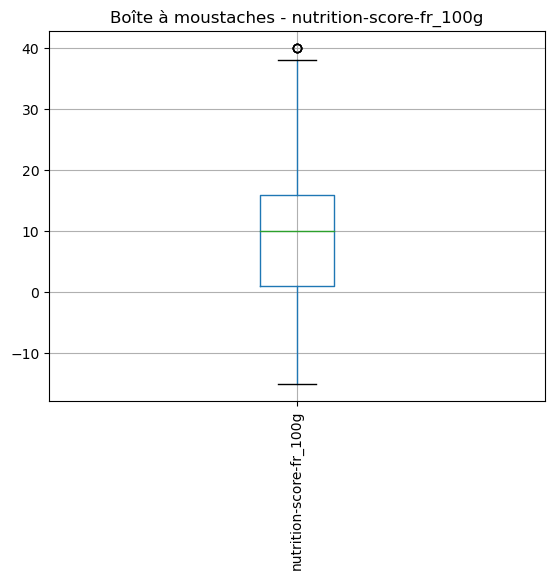

In [221]:
# Boucle pour parcourir chaque colonne du dataframe
for i in OpenFoodProducts_details.columns:
    # Vérifiez le type pour chaque colonne
    if pd.api.types.is_numeric_dtype(OpenFoodProducts_details[i]):
        # Si la colonne est de type numérique, je souhaiterai générer une boite à moustache
        OpenFoodProducts_details.boxplot(column=i)
        plt.xticks(rotation='vertical') 
        plt.title(f"Boîte à moustaches - {i}")
        plt.show()


In [222]:
OpenFoodProducts_details.describe()

energy_100g  saturated-fat_100g    sugars_100g     salt_100g  \
count  260219.000000       160815.000000  207875.000000  2.211780e+05   
mean     1116.159059            7.316862      18.836645  1.833934e+00   
std       784.412709            8.565257      21.775376  6.673844e+00   
min         0.000000            0.000100       0.000100  5.000000e-08   
25%       372.000000            1.540000       3.200000  1.524000e-01   
50%      1096.000000            4.500000       9.100000  7.721600e-01   
75%      1674.000000           10.700000      28.950000  1.524000e+00   
max      3699.000000          100.000000     100.000000  1.000000e+02   

          fiber_100g  proteins_100g  fruits-vegetables-nuts_100g  \
count  132048.000000  206287.000000                  2074.000000   
mean        4.308964       8.919932                    46.050275   
std         5.065973       8.210266                    28.703994   
min         0.000100       0.000100                     1.000000   
25%         1.500000       3.330000                    20.350000   
50%         3.000000       6.670000                    50.000000   
75%         5.400000      12.100000                    63.000000   
max       100.000000     100.000000                   100.000000   

       nutrition-score-fr_100g  
count            221210.000000  
mean                  9.165535  
std                   9.055903  
min                 -15.000000  
25%                   1.000000  
50%                  10.000000  
75%                  16.000000  
max                  40.000000

In [223]:
OpenFoodProducts_details_short = OpenFoodProducts_details.iloc[:,list(range(-8, 0))]

Regardons maintenant la répartition des différents produits afin d'y voir des corrélation entre les différents variables

In [224]:
def generate_correlation_plot(x_axis, y_axis):
    sns.pairplot(OpenFoodProducts_details_short, x_vars=x_axis, y_vars=y_axis)

In [225]:
import ipywidgets as widgets

# Liste des colonnes numériques pour les axes x et y
columns_numeric = OpenFoodProducts_details_short.select_dtypes(include='number').columns.tolist()

# Création des listes déroulantes pour les axes x et y
x_axis_dropdown = widgets.Dropdown(options=columns_numeric, description='Axe X:')
y_axis_dropdown = widgets.Dropdown(options=columns_numeric, description='Axe Y:')

In [226]:
from ipywidgets import interact

@interact(x_axis=x_axis_dropdown, y_axis=y_axis_dropdown)
def update_correlation_plot(x_axis, y_axis):
    generate_correlation_plot(x_axis, y_axis)

interactive(children=(Dropdown(description='Axe X:', options=('energy_100g', 'saturated-fat_100g', 'sugars_100…

Une autre étude que nous faisons en data-science est l’étude de la variance (Méthode Anova).Le test de l'ANOVA est utilisé pour déterminer si les moyennes de plusieurs groupes sont statistiquement différentes les unes des autres. 

In [227]:
def run_anova(column):
    OpenFoodProducts_sample = OpenFoodProducts[['product_name', column]]
    OpenFoodProducts_sample = OpenFoodProducts_sample.dropna(axis=0)
    grouped_data = OpenFoodProducts_sample.groupby('product_name')
    anova_result = f_oneway(*[group[column] for name, group in grouped_data])
    print('Pour la colonne :', column)
    print('Valeur F :', anova_result.statistic)
    print('p-value :', anova_result.pvalue)
    if anova_result.statistic < 0.05:
        print('Nous pouvons conclure que les scores nutritionnels des différents groupes sont significativement similaires')
    else:
        print('Nous pouvons conclure que les scores nutritionnels des différents groupes sont significativement différents')

    if anova_result.pvalue > 0.95:
        print("et le comportement observé entre les groupes n'est probablement pas dû au hasard.")
    else:
        print("Et il n'y a pas suffisamment de preuves pour affirmer que ce comportement n'est pas dû au hasard.")

In [228]:
# Liste des colonnes disponibles pour l'ANOVA
columns_list = ['energy_100g', 'saturated-fat_100g', 'sugars_100g', 'salt_100g', 'fiber_100g', 'proteins_100g', 'fruits-vegetables-nuts_100g', 'nutrition-score-fr_100g']

In [229]:
column_dropdown = widgets.Dropdown(
    options=columns_list,
    description='Je souhaiterai analyser la variation de la valeur nutritionnelle :',
)

# Lier la fonction d'ANOVA à l'événement de changement de valeur dans le dropdown
widgets.interactive(run_anova, column=column_dropdown)

interactive(children=(Dropdown(description='Je souhaiterai analyser la variation de la valeur nutritionnelle :…

# Imputation des valeurs manquantes

On imputera les énergies manquantes par la moyenne, car la différence de groupe est non significative

In [230]:
imputer = SimpleImputer(strategy="mean")
OpenFoodProducts_details["energy_100g"] = imputer.fit_transform(OpenFoodProducts_details[["energy_100g"]])

/var/folders/7b/9clccc0960v7tsff315g71dh0000gn/T/ipykernel_8296/945524759.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OpenFoodProducts_details["energy_100g"] = imputer.fit_transform(OpenFoodProducts_details[["energy_100g"]])


In [231]:
OpenFoodProducts_details_short=OpenFoodProducts_details

Ensuite, on utilisera la méthode Iterative Imputer pour compléter notre base de données. La méthode IterativeImputer est une technique d'imputation de données manquantes qui utilise un modèle prédictif pour estimer les valeurs manquantes

In [232]:
# Création de l'objet IterativeImputer
imputer = IterativeImputer()
# Stockez les noms des colonnes
colonne_names = {i: nom for i, nom in enumerate(OpenFoodProducts_details_short.columns)}

# Création de l'objet IterativeImputer en spécifiant les colonnes à imputer
columns_to_impute = ['energy_100g', 'saturated-fat_100g', 'sugars_100g', 'proteins_100g']
imputer = IterativeImputer(add_indicator=False, missing_values=np.nan, random_state=0)

# Imputer uniquement les colonnes sélectionnées
OpenFoodProducts_details_short_filled = OpenFoodProducts_details_short.copy()
OpenFoodProducts_details_short_filled[columns_to_impute] = imputer.fit_transform(OpenFoodProducts_details_short[columns_to_impute])

In [233]:
# On imputera les données manquantes par leur médiane
imputer = SimpleImputer(strategy="median")
OpenFoodProducts_details_short_filled["fiber_100g"] = imputer.fit_transform(OpenFoodProducts_details_short_filled[["fiber_100g"]])

In [234]:
# On imputera les données manquantes par leur médiane
imputer = SimpleImputer(strategy="median")
OpenFoodProducts_details_short_filled["fruits-vegetables-nuts_100g"] = imputer.fit_transform(OpenFoodProducts_details_short_filled[["fruits-vegetables-nuts_100g"]])

In [235]:
# On imputera les données manquantes par leur médiane
imputer = SimpleImputer(strategy="median")
OpenFoodProducts_details_short_filled['nutrition-score-fr_100g'] = imputer.fit_transform(OpenFoodProducts_details_short_filled[['nutrition-score-fr_100g']])

In [236]:
# On imputera les données manquantes par leur médiane
imputer = SimpleImputer(strategy="median")
OpenFoodProducts_details_short_filled['salt_100g'] = imputer.fit_transform(OpenFoodProducts_details_short_filled[['salt_100g']])

In [237]:
# Réaffectez les noms des colonnes
OpenFoodProducts_details_short_filled.rename(columns=colonne_names, inplace=True)

Ci dessous le tableau descriptif de la base de donnée remplie avec notre technique d'imputation (1er) et le deuxième représente la description de la base de données avant la complétion

In [238]:
OpenFoodProducts_details_short_filled.describe()

energy_100g  saturated-fat_100g    sugars_100g     salt_100g  \
count  262238.000000       262238.000000  262238.000000  2.622380e+05   
mean     1116.159059            5.808243      17.063094  1.667686e+00   
std       781.387222            7.361806      20.985441  6.141267e+00   
min         0.000000           -1.090099    -145.600390  5.000000e-08   
25%       380.000000            0.790000       3.196565  2.200000e-01   
50%      1105.000000            3.570000       9.000000  7.721600e-01   
75%      1674.000000            8.312285      26.000000  1.348740e+00   
max      3699.000000          100.000000     100.000000  1.000000e+02   

          fiber_100g  proteins_100g  fruits-vegetables-nuts_100g  \
count  262238.000000  262238.000000                262238.000000   
mean        3.659119       7.850263                    49.968762   
std         3.653934       7.955946                     2.575954   
min         0.000100     -19.087709                     1.000000   
25%         2.900000       3.200000                    50.000000   
50%         3.000000       5.700000                    50.000000   
75%         3.000000      10.710000                    50.000000   
max       100.000000     100.000000                   100.000000   

       nutrition-score-fr_100g  
count            262238.000000  
mean                  9.296090  
std                   8.322896  
min                 -15.000000  
25%                   2.000000  
50%                  10.000000  
75%                  15.000000  
max                  40.000000

In [239]:
OpenFoodProducts_details_short.describe()

energy_100g  saturated-fat_100g    sugars_100g     salt_100g  \
count  262238.000000       160815.000000  207875.000000  2.211780e+05   
mean     1116.159059            7.316862      18.836645  1.833934e+00   
std       781.387222            8.565257      21.775376  6.673844e+00   
min         0.000000            0.000100       0.000100  5.000000e-08   
25%       380.000000            1.540000       3.200000  1.524000e-01   
50%      1105.000000            4.500000       9.100000  7.721600e-01   
75%      1674.000000           10.700000      28.950000  1.524000e+00   
max      3699.000000          100.000000     100.000000  1.000000e+02   

          fiber_100g  proteins_100g  fruits-vegetables-nuts_100g  \
count  132048.000000  206287.000000                  2074.000000   
mean        4.308964       8.919932                    46.050275   
std         5.065973       8.210266                    28.703994   
min         0.000100       0.000100                     1.000000   
25%         1.500000       3.330000                    20.350000   
50%         3.000000       6.670000                    50.000000   
75%         5.400000      12.100000                    63.000000   
max       100.000000     100.000000                   100.000000   

       nutrition-score-fr_100g  
count            221210.000000  
mean                  9.165535  
std                   9.055903  
min                 -15.000000  
25%                   1.000000  
50%                  10.000000  
75%                  16.000000  
max                  40.000000

Cette méthode n'est pas la plus optimale mais cela nous permet de compléter notre set afin de procéder à l'ACP

# Analyse en composantes principales (ACP)

L'Analyse en Composantes Principales (ACP) est une technique statistique largement utilisée pour transformer des données multidimensionnelles complexes en un ensemble de nouvelles variables, appelées "composantes principales" (F1,F2,F3...), qui capturent l'essentiel de la variabilité des données d'origine. L'objectif principal de l'ACP est de réduire la dimensionnalité des données tout en préservant autant d'informations que possible.

Pour commencer, on va d'abord remettre à l'échelle nos données. Cela permet de centrer les données autour de zéro et de leur donner une variance unitaire.

Notre tableau descriptif de notre base de donnée scalé. On remarquera que la moyenne de toutes les données est à 0 et l'écart type à 1

In [240]:
# On instancie notre scaler : 
scaler = StandardScaler()

# On le fit : 
scaler.fit(OpenFoodProducts_details_short_filled)

# On l'entraine : 
OpenFoodProducts_details_short_filled_scaled = scaler.transform(OpenFoodProducts_details_short_filled)

# On peut faire les 2 opérations en une ligne : 
OpenFoodProducts_details_short_filled_scaled = scaler.fit_transform(OpenFoodProducts_details_short_filled)

# On le transforme en DataFrame : 
OpenFoodProducts_details_short_filled_scaled = pd.DataFrame(OpenFoodProducts_details_short_filled_scaled)

In [241]:
OpenFoodProducts_details_short_filled_scaled.rename(columns=colonne_names, inplace=True)

In [242]:
OpenFoodProducts_details_short_filled_scaled.describe().round(2)

energy_100g  saturated-fat_100g  sugars_100g  salt_100g  fiber_100g  \
count    262238.00           262238.00    262238.00  262238.00   262238.00   
mean          0.00               -0.00        -0.00      -0.00       -0.00   
std           1.00                1.00         1.00       1.00        1.00   
min          -1.43               -0.94        -7.75      -0.27       -1.00   
25%          -0.94               -0.68        -0.66      -0.24       -0.21   
50%          -0.01               -0.30        -0.38      -0.15       -0.18   
75%           0.71                0.34         0.43      -0.05       -0.18   
max           3.31               12.79         3.95      16.01       26.37   

       proteins_100g  fruits-vegetables-nuts_100g  nutrition-score-fr_100g  
count      262238.00                    262238.00                262238.00  
mean            0.00                         0.00                    -0.00  
std             1.00                         1.00                     1.00  
min            -3.39                       -19.01                    -2.92  
25%            -0.58                         0.01                    -0.88  
50%            -0.27                         0.01                     0.08  
75%             0.36                         0.01                     0.69  
max            11.58                        19.42                     3.69

On instancie notre ACP et puis on l'entraine avec nos données scalés :

In [243]:
pca = PCA()

In [244]:
pca.fit(OpenFoodProducts_details_short_filled_scaled)

PCA()

In [245]:
pca.explained_variance_ratio_

array([0.31018932, 0.18982451, 0.13073231, 0.12517244, 0.11612786,
       0.05392517, 0.04553157, 0.02849682])

In [246]:
scree = (pca.explained_variance_ratio_*100).round(2)

Intéressons nous maintenant à la variance captée par chaque nouvelle composante.
La premi!ère composante (F1) capte 31% de la variance de nos données, 
La 2ème : 19%
...
Cela signifie que la première composante explique 31% des informations qu'on a dans notre base de donnée initiale et ainsi de suite

In [247]:
scree_cum = scree.cumsum().round()
scree_cum

array([ 31.,  50.,  63.,  76.,  87.,  93.,  97., 100.])

On a l'habitude en exploration de données de sommer ces variances, car plus on avance dans les composantes, et plus, nous détenons des informations

In [248]:
x_list = range(1, 9)

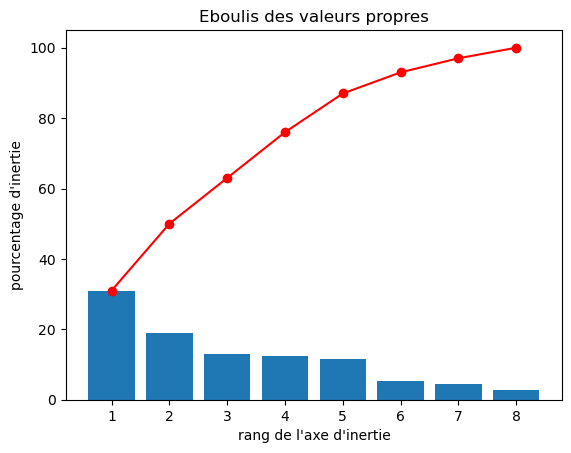

In [249]:
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

On voit ici que près de 75% de la variance (ou de l'information de nos données) est comprise dans les 4 premières composantes, et près de 90% dans les 5 premières. On remarque aussi que les 7 premières composantes définissent automatiquement la dernière. 

On va à présent voir comment ces nouvelles composantes sont "calculées" à partir de nos valeurs nutritionnelles initiales

In [250]:
pcs = pca.components_

In [251]:
pcs = pd.DataFrame(pcs)

In [252]:
pcs.rename(columns=colonne_names, inplace=True)
features = pcs.columns
pcs.index = [f"F{i}" for i in x_list]

In [253]:
pcs.T.round(2)

F1    F2    F3    F4    F5    F6    F7    F8
energy_100g                  0.56  0.12 -0.10 -0.00  0.03 -0.21 -0.50 -0.61
saturated-fat_100g           0.52  0.08  0.05 -0.02 -0.18  0.79 -0.05  0.24
sugars_100g                  0.35 -0.54 -0.15  0.04  0.31 -0.29 -0.25  0.56
salt_100g                   -0.03  0.08  0.83  0.20  0.47  0.06 -0.17 -0.01
fiber_100g                   0.12  0.40 -0.41  0.06  0.73  0.10  0.33 -0.01
proteins_100g                0.14  0.71  0.08 -0.03 -0.24 -0.38 -0.14  0.49
fruits-vegetables-nuts_100g  0.01  0.00 -0.14  0.98 -0.17 -0.01  0.02 -0.00
nutrition-score-fr_100g      0.51 -0.12  0.29 -0.00 -0.15 -0.30  0.72 -0.11

Alors, comment calcule t-on la première composante F1 ?
et bien c'est assez simple :
F1 = (0.56 * energy_100g) + (0.52 * saturated-fat_100g) + ... + (0.51 * nutrition-score-fr_100g)

et F2 ?

F2 = (0.12 * energy_100g) + (0.08 * saturated-fat_100g) + ... + (-0,12* nutrition-score-fr_100g)

Et ainsi de suite 

Cette heatmap permet de visualiser aussi très rapidement le poids de chaque valeur sur chaque composante

<Axes: >

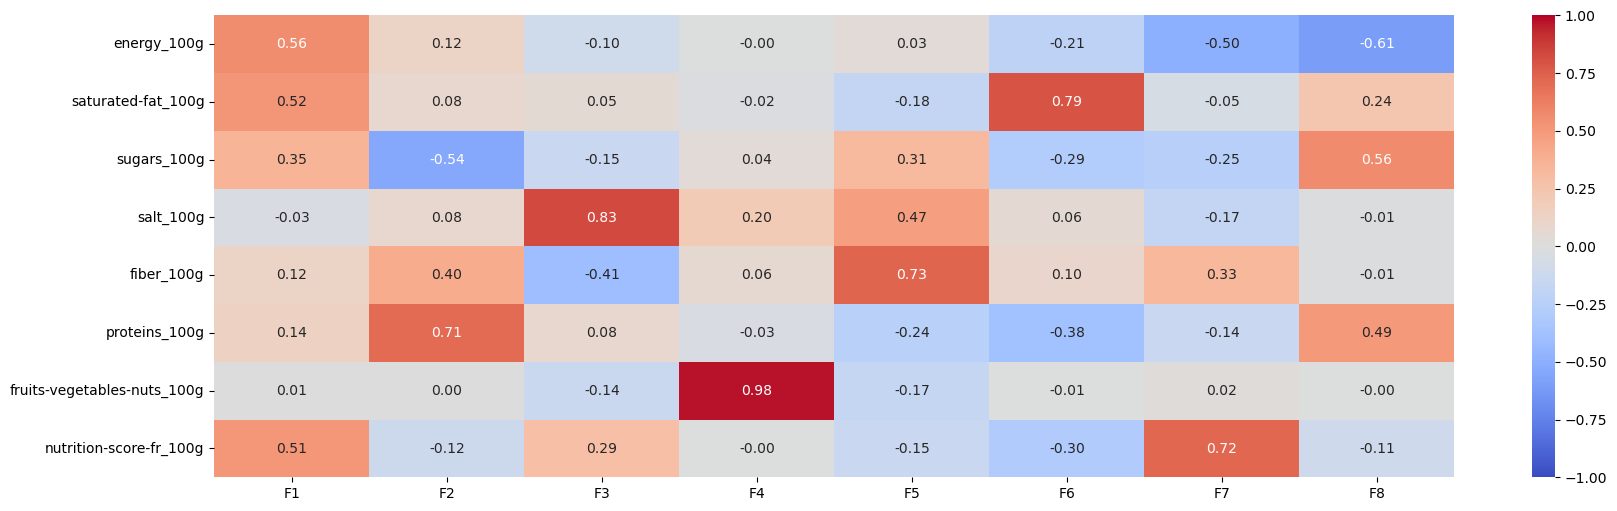

In [254]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

Maintenant, essayons de comprendre la corrélation entre ces différentes nouvelles composantes

In [255]:
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

In [256]:
# Définition des conditions et des valeurs correspondantes pour le Nutriscore_Code
conditions = [
    (OpenFoodProducts_details_short_filled['nutrition-score-fr_100g'] <= -1),
    (OpenFoodProducts_details_short_filled['nutrition-score-fr_100g'] <= 2),
    (OpenFoodProducts_details_short_filled['nutrition-score-fr_100g'] <= 10),
    (OpenFoodProducts_details_short_filled['nutrition-score-fr_100g'] <= 18),
    (OpenFoodProducts_details_short_filled['nutrition-score-fr_100g'] > 18)
]
values = [1, 2, 3, 4, 5]

# Ajout de la colonne Nutriscore_Code avec les valeurs correspondantes
OpenFoodProducts_details_short_filled['Nutriscore_Code'] = np.select(conditions, values)

In [257]:
OpenFoodProducts_details_short_filled_proj = pca.transform(OpenFoodProducts_details_short_filled_scaled)

In [258]:
def display_factorial_planes(   OpenFoodProducts_details_short_filled_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    OpenFoodProducts_details_short_filled__projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme OpenFoodProducts_details_short_filled__projected en np.array
    OpenFoodProducts_details_short_filled_ = np.array(OpenFoodProducts_details_short_filled_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= OpenFoodProducts_details_short_filled_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   OpenFoodProducts_details_short_filled_[:, x], OpenFoodProducts_details_short_filled_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=OpenFoodProducts_details_short_filled_[:, x], y=OpenFoodProducts_details_short_filled_[:, y], hue=c, palette='RdYlGn_r')

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(OpenFoodProducts_details_short_filled_[:, x]).max() *1.1
    y_max = np.abs(OpenFoodProducts_details_short_filled_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        # Si si je l'ai bien lu la fonction
        for i,(_x,_y) in enumerate(OpenFoodProducts_details_short_filled_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    # Titre et display
    plt.title((f"Projection des individus (sur F{x+1} et F{y+1})"))
    plt.show()

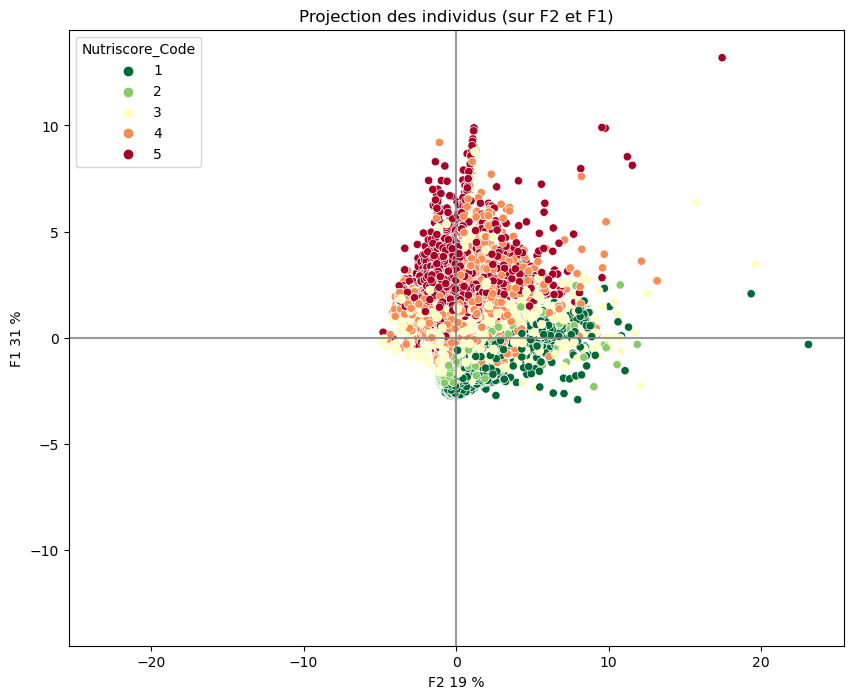

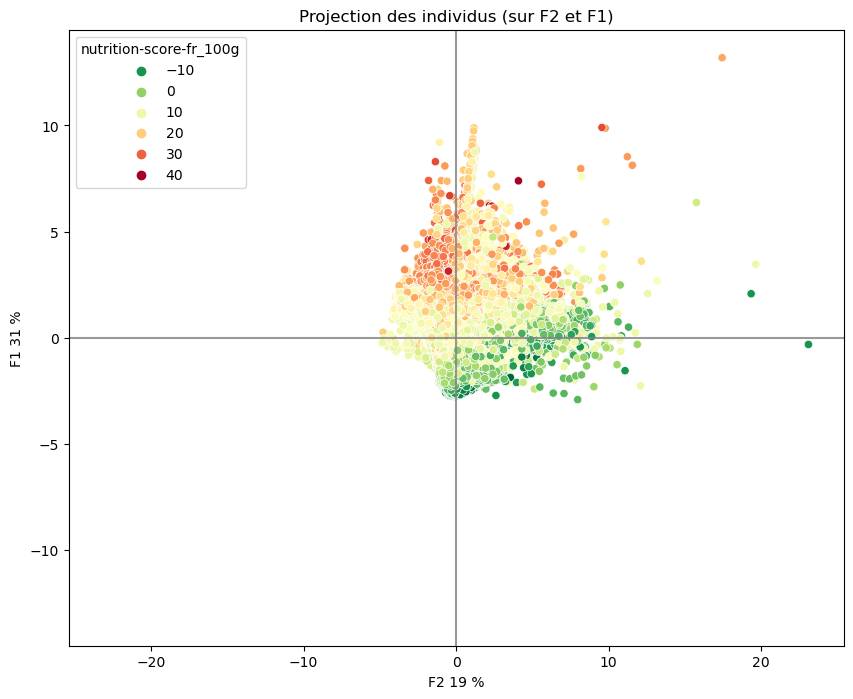

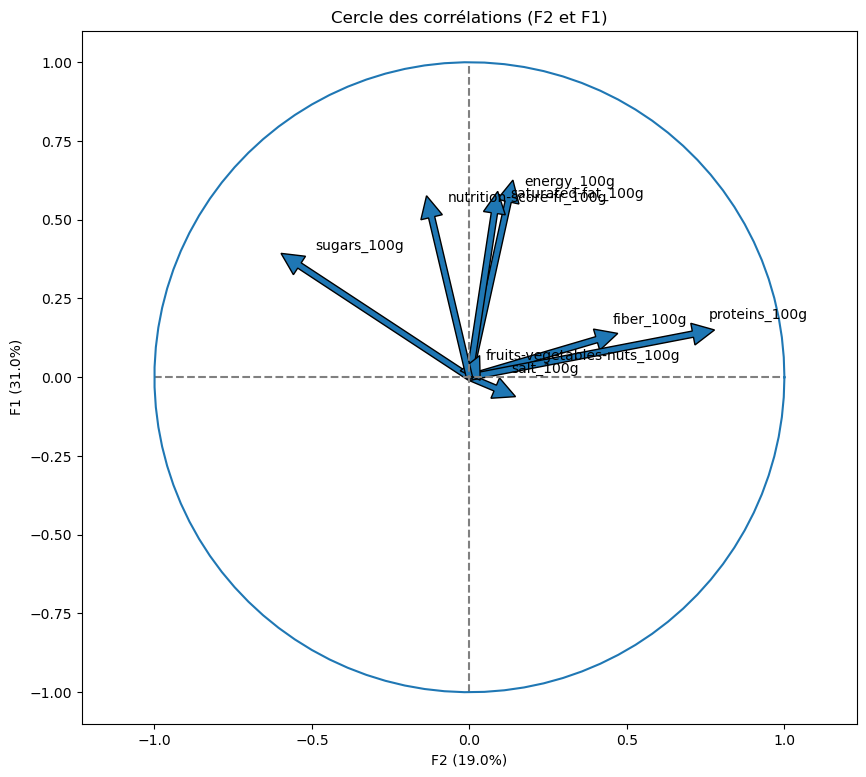

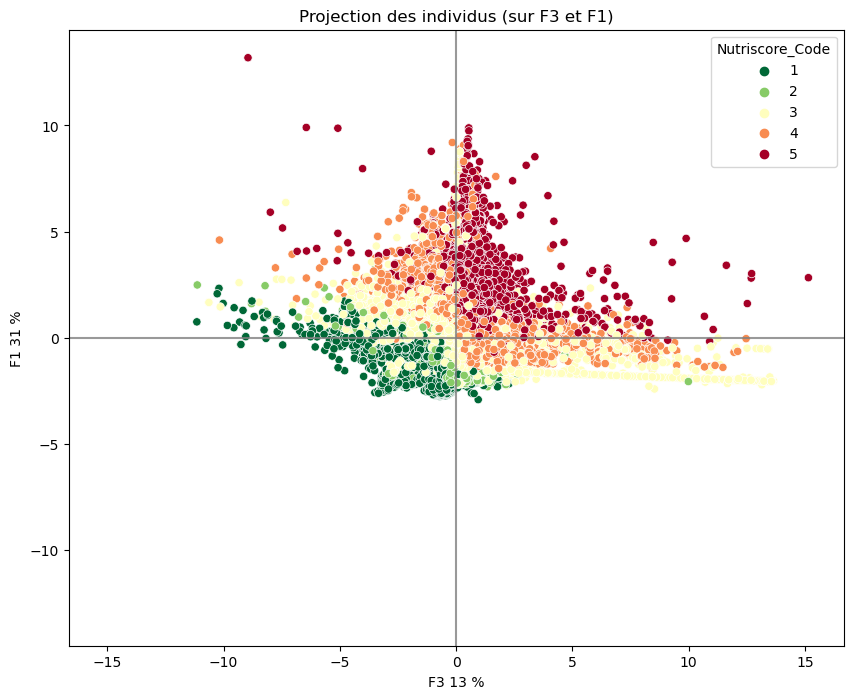

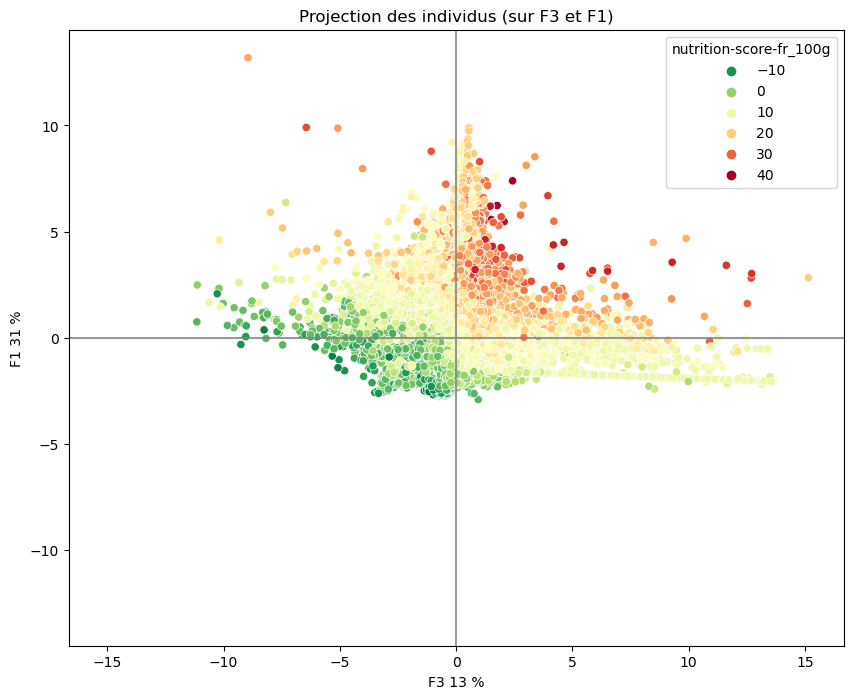

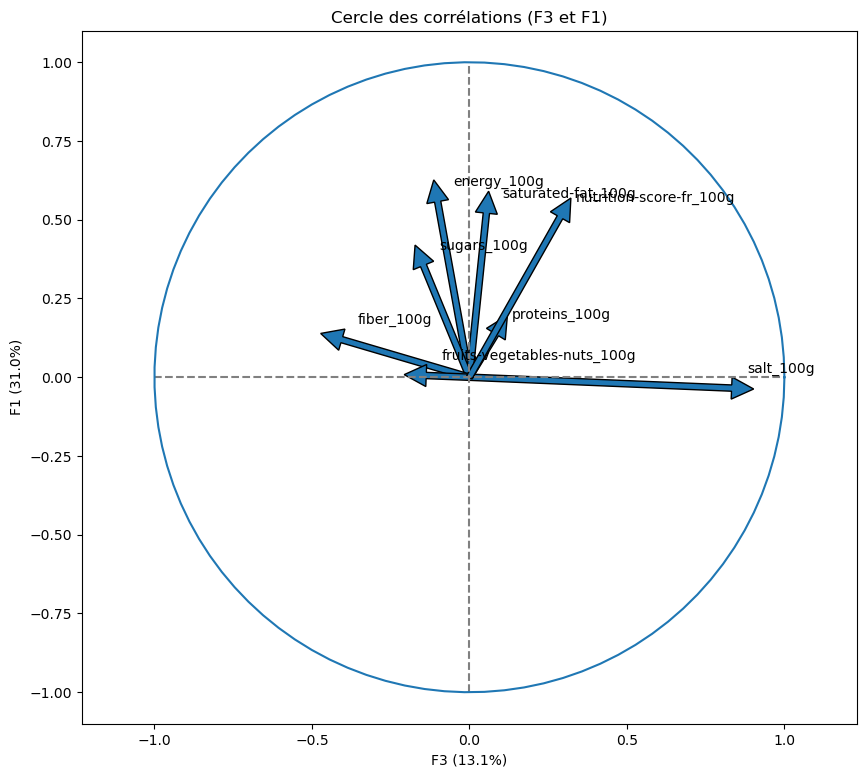

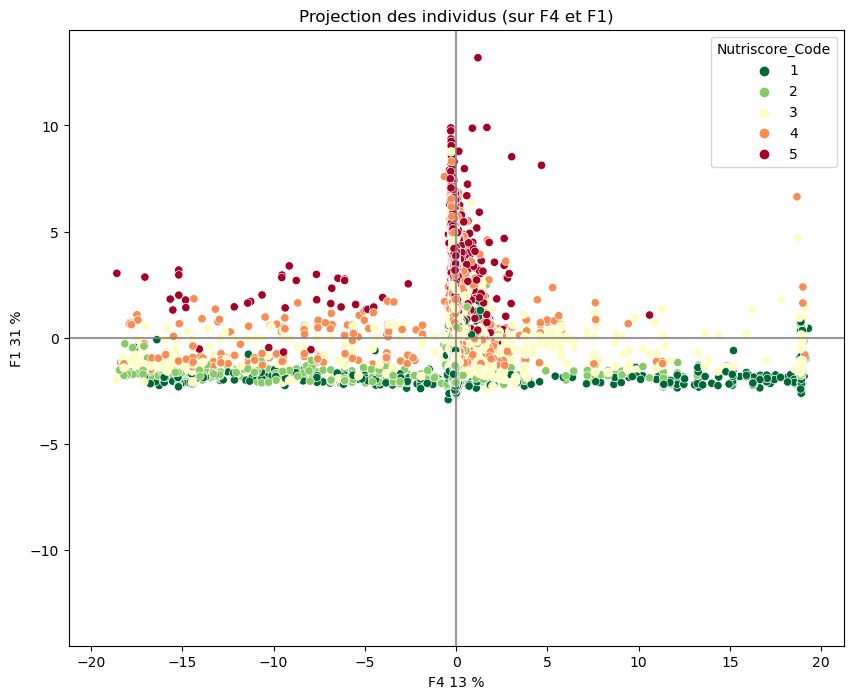

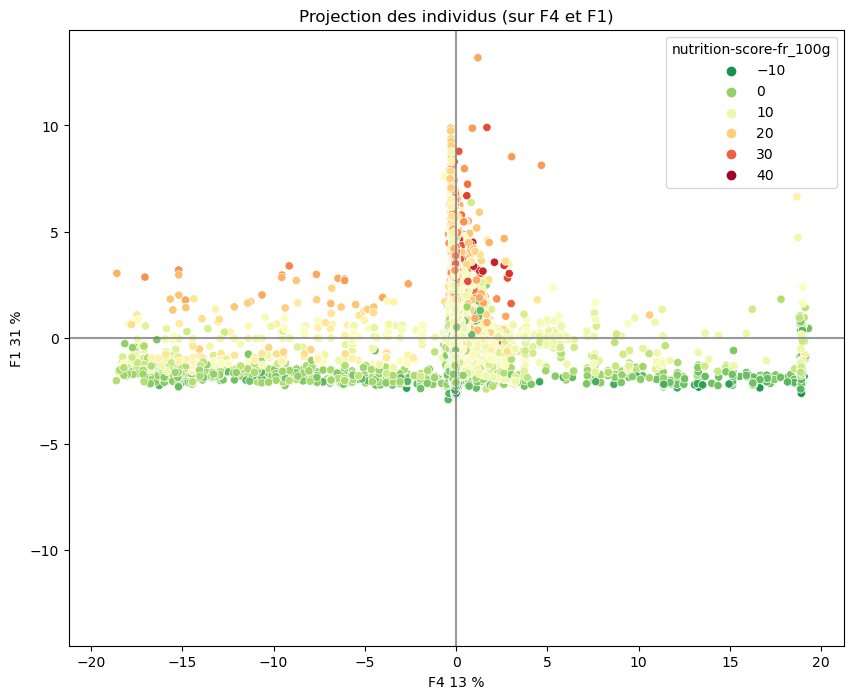

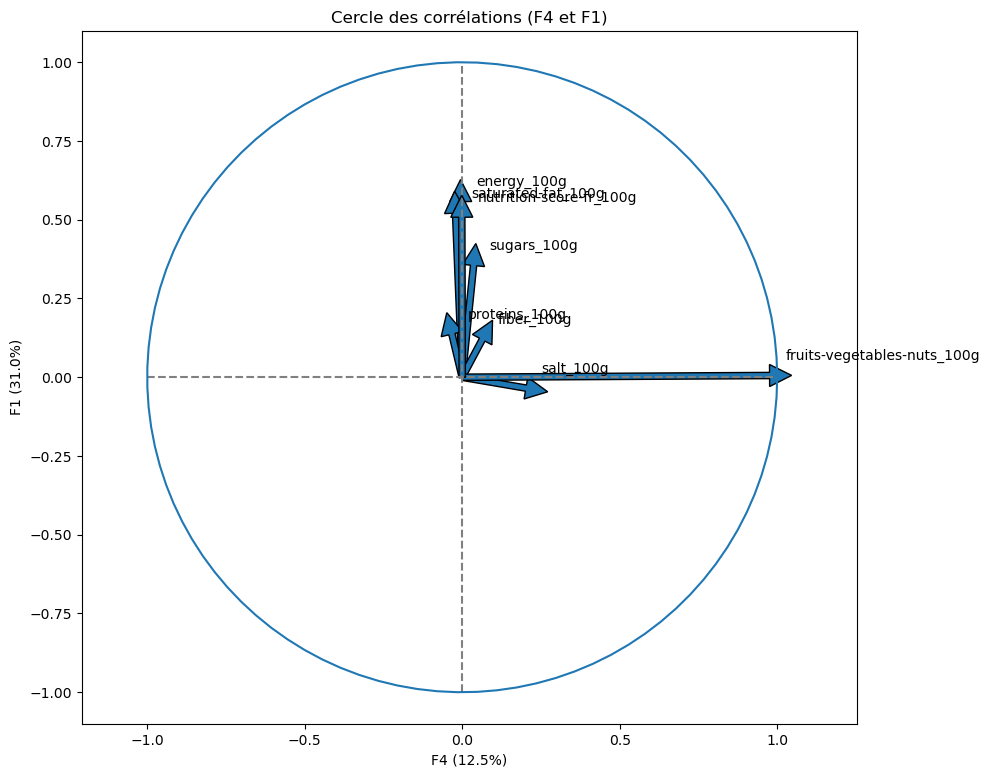

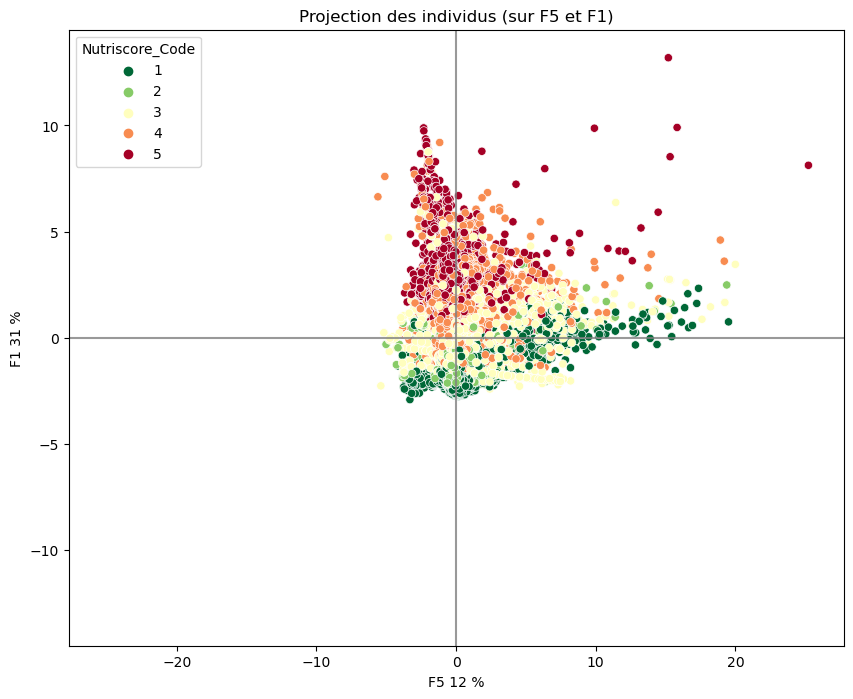

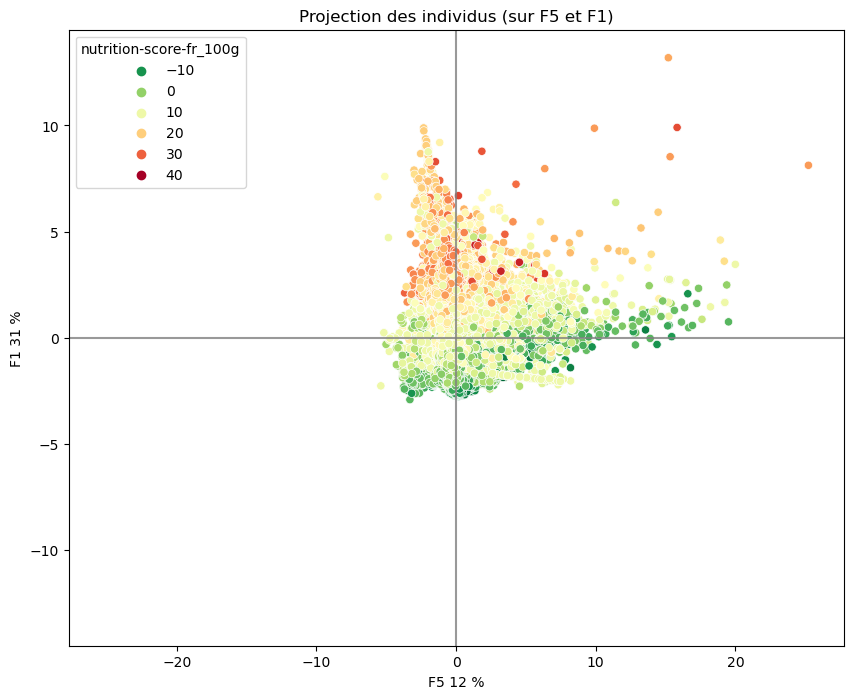

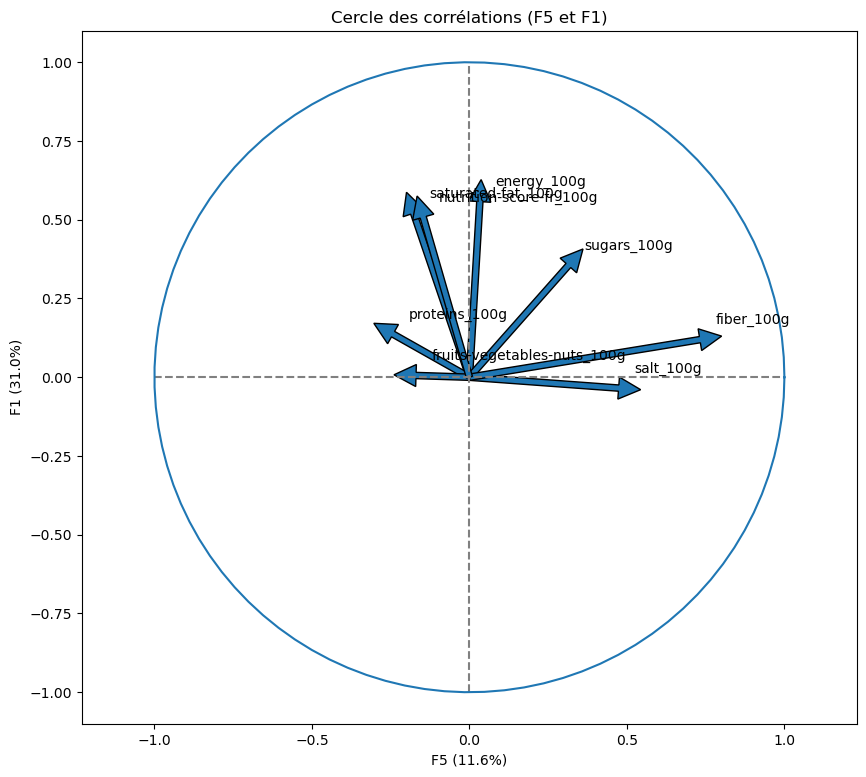

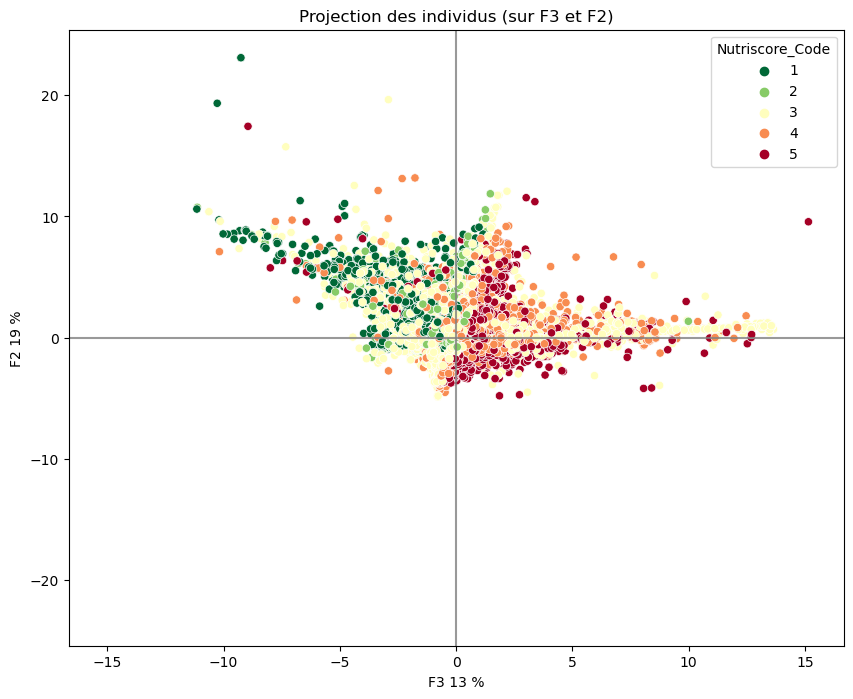

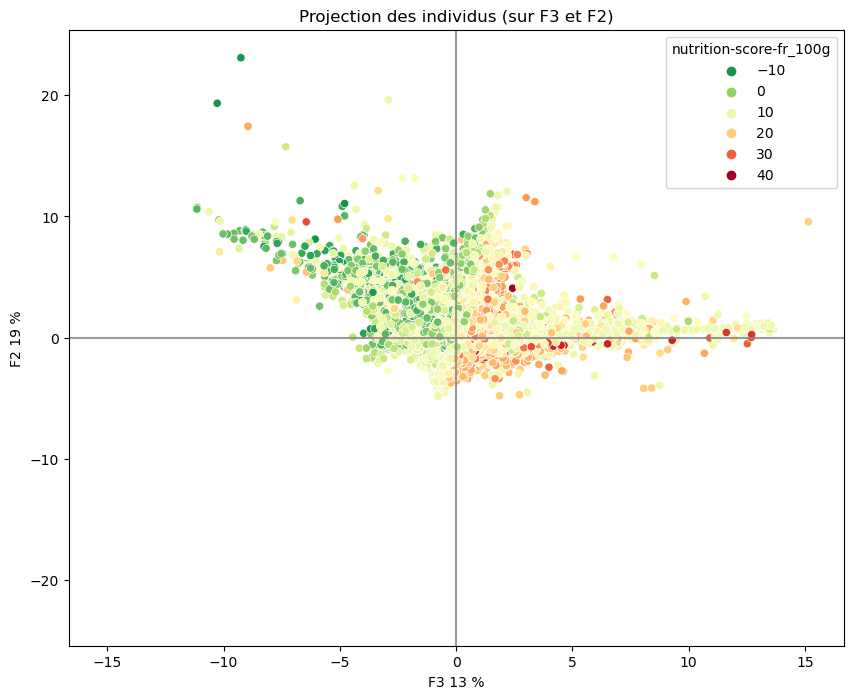

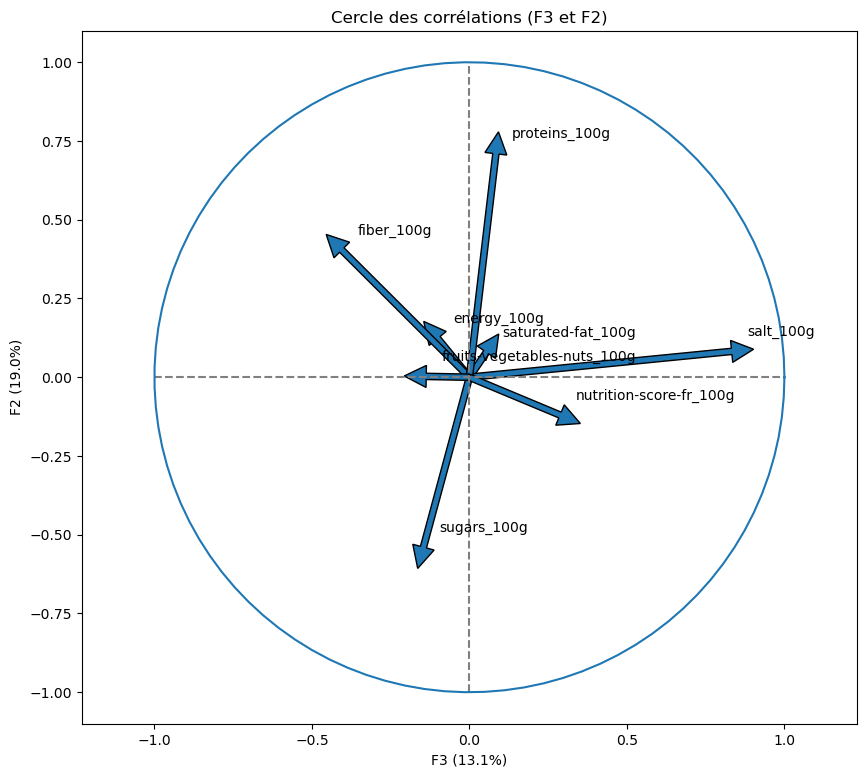

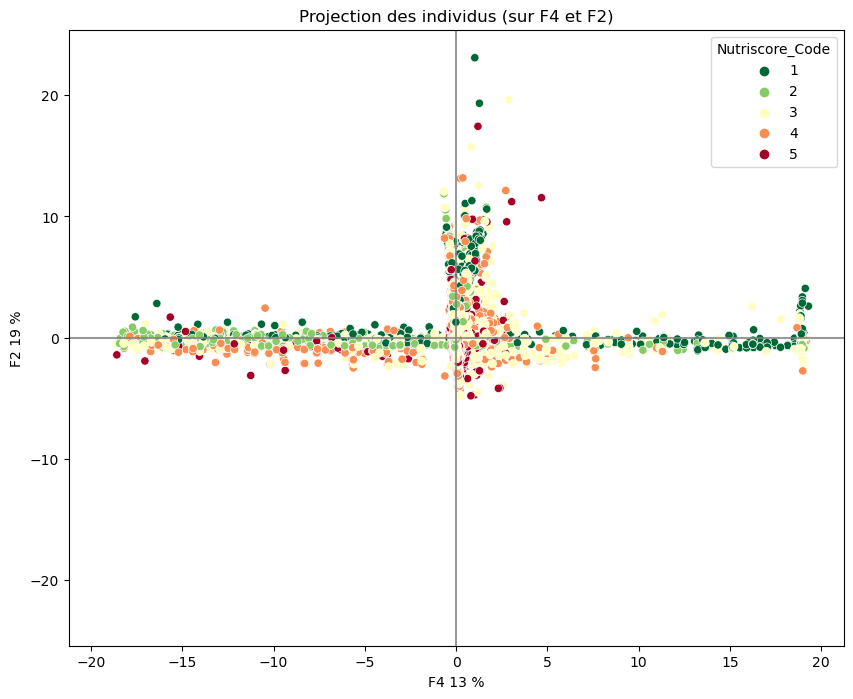

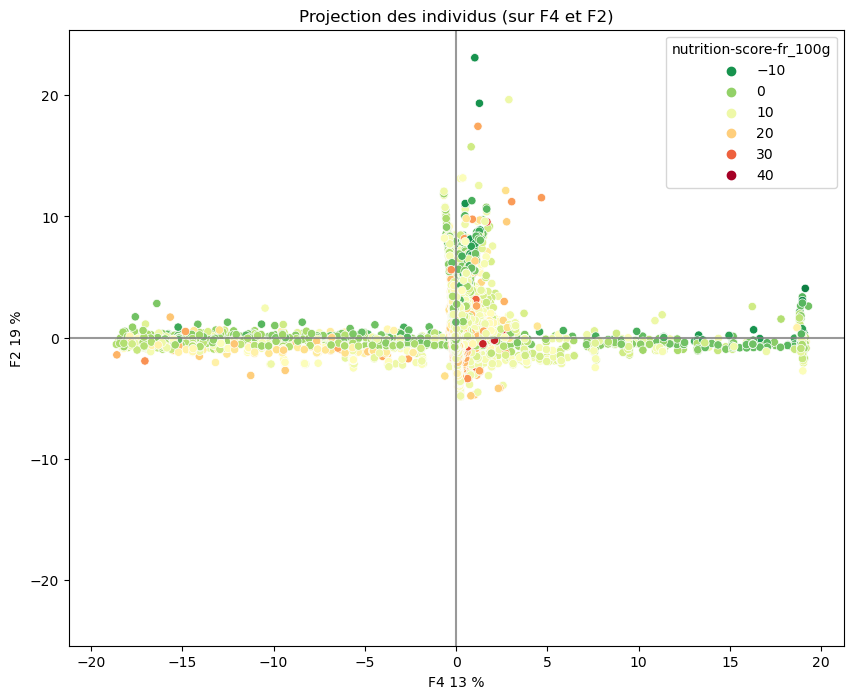

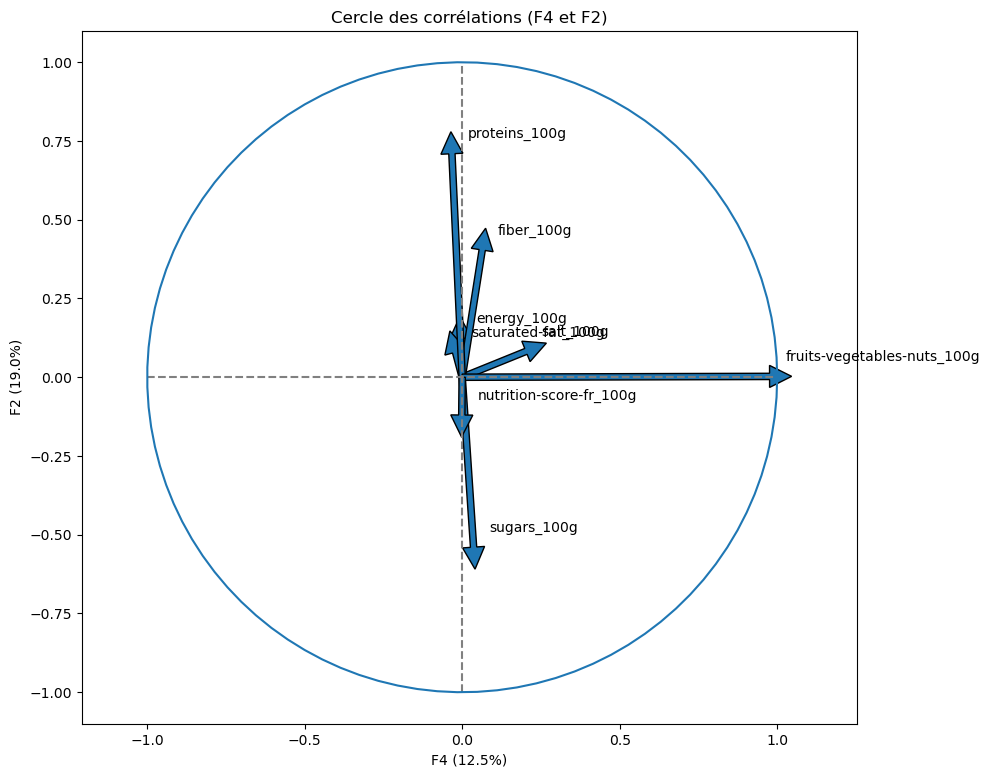

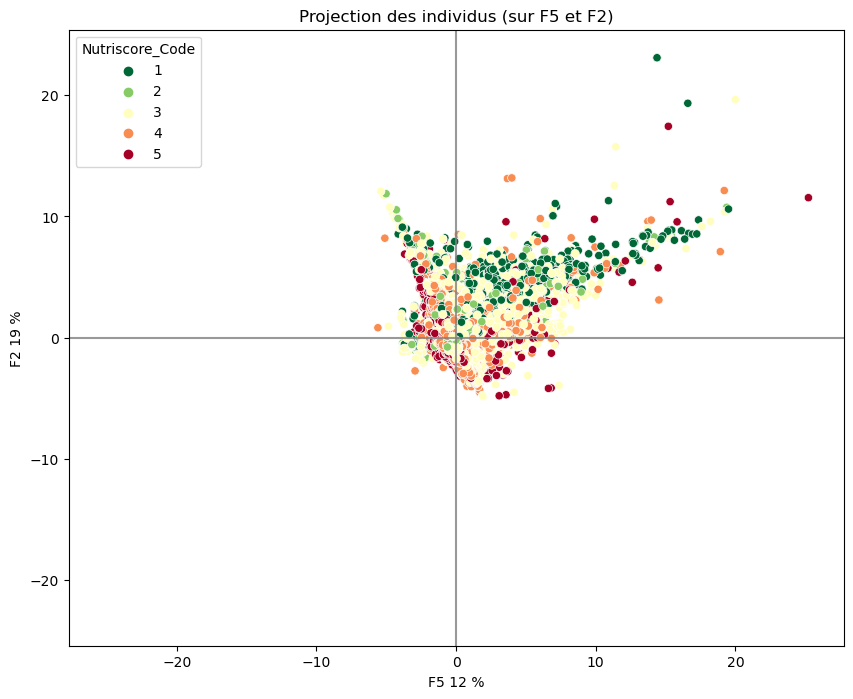

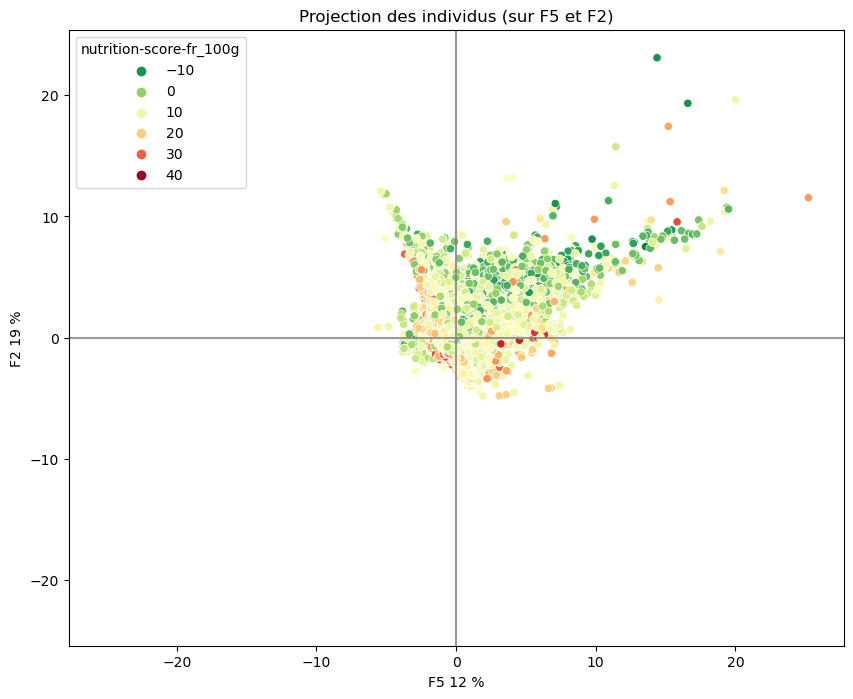

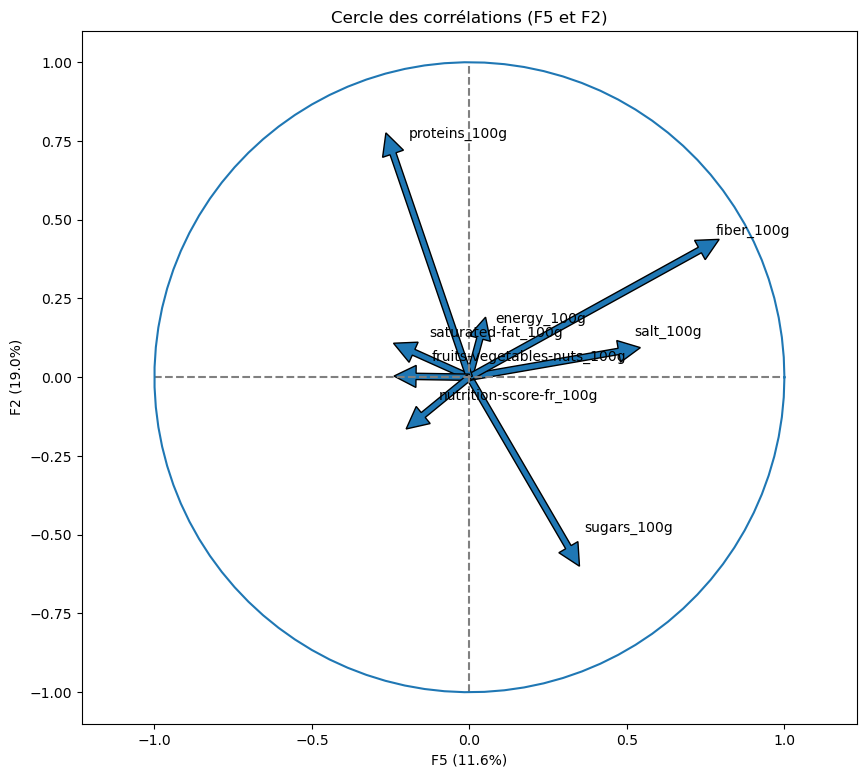

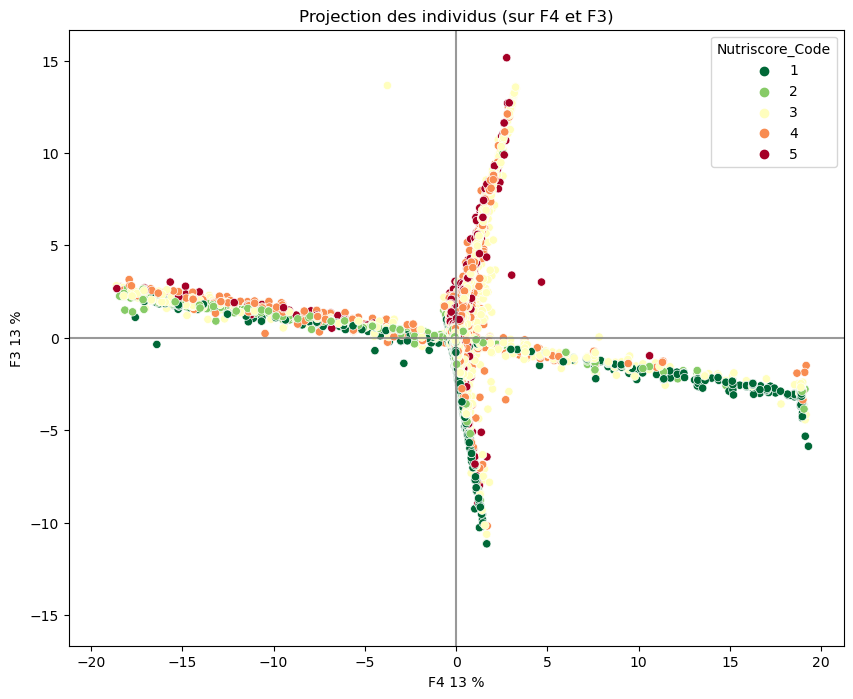

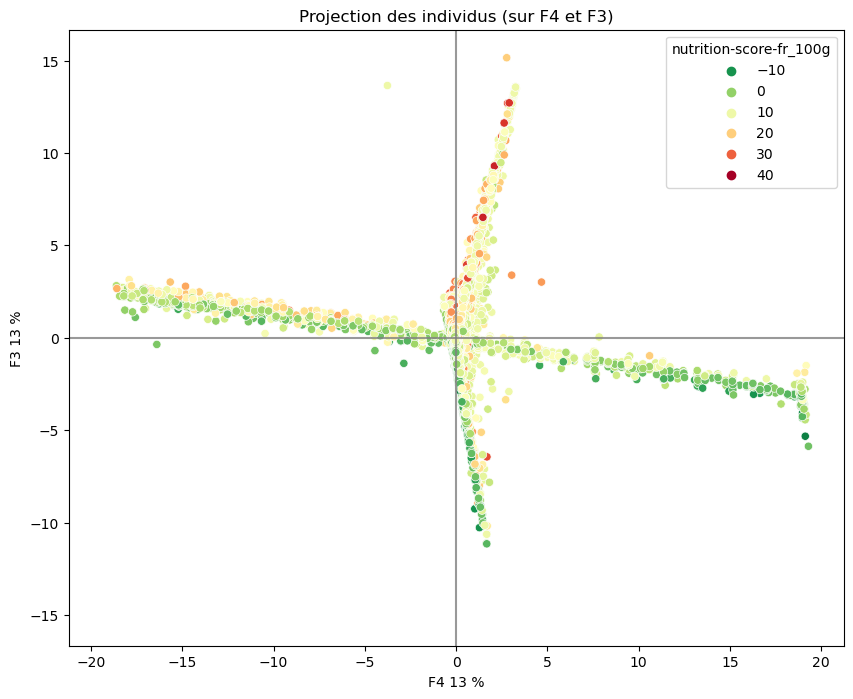

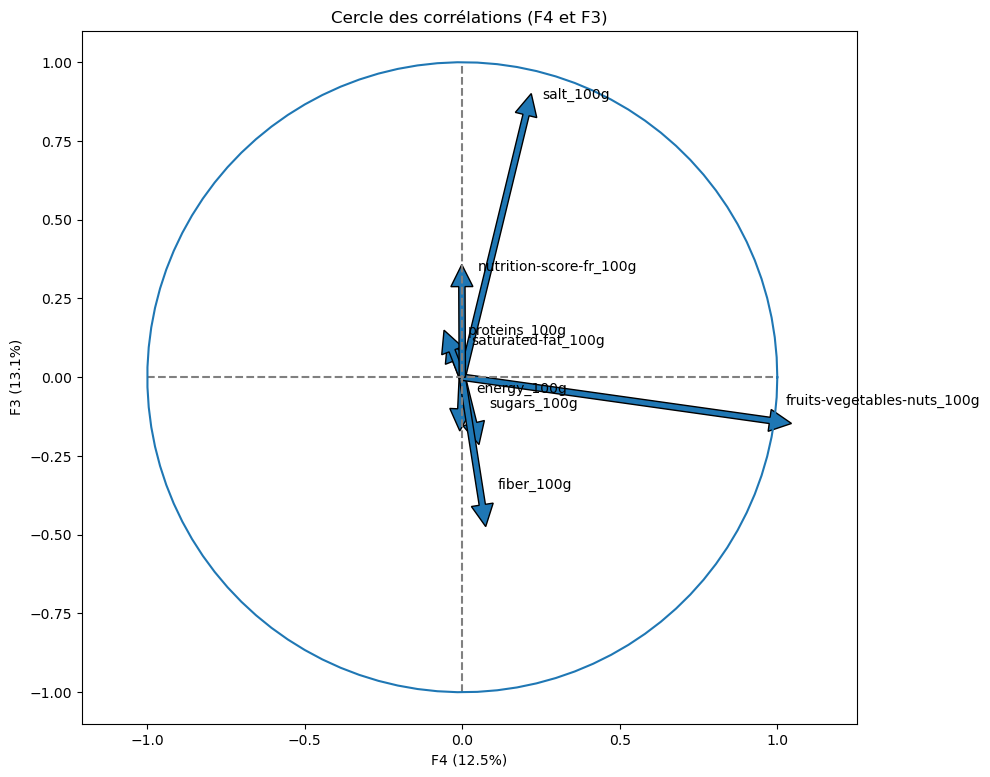

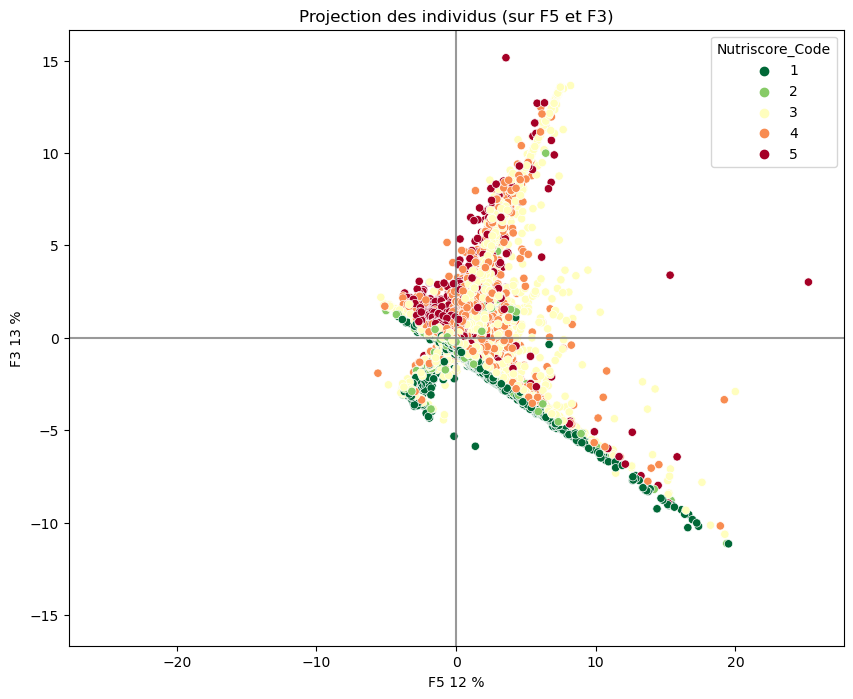

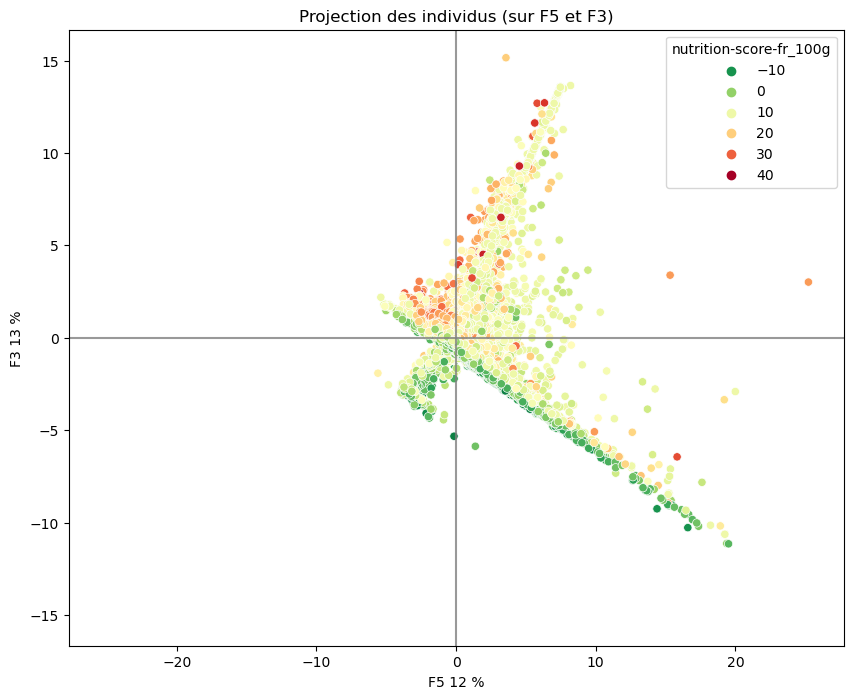

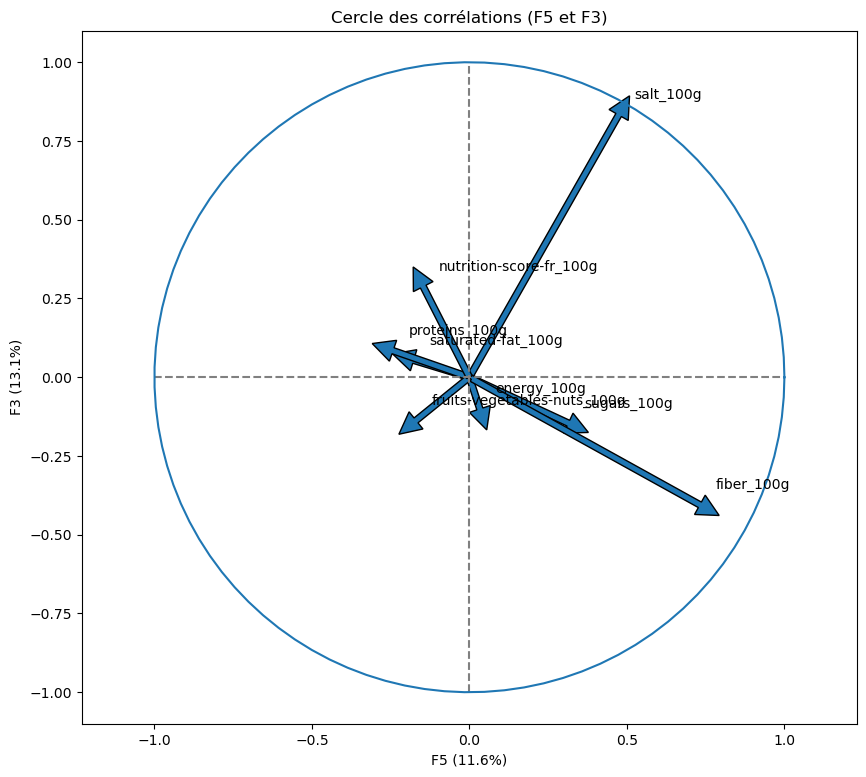

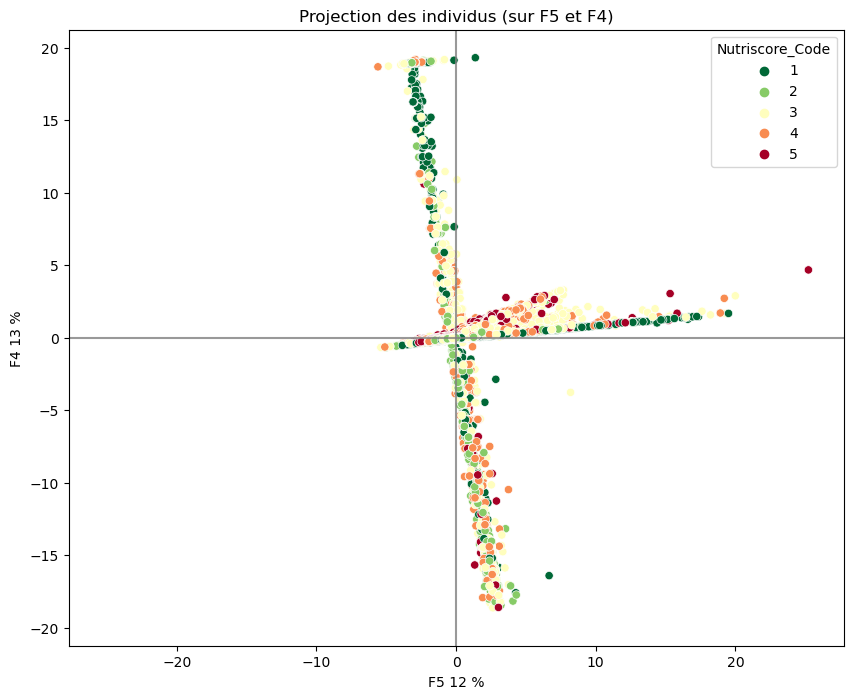

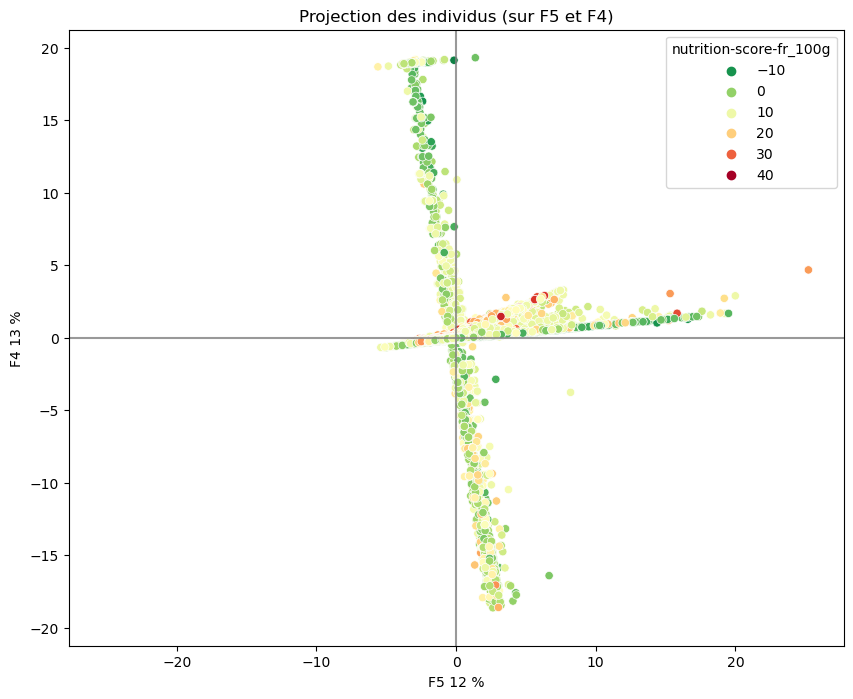

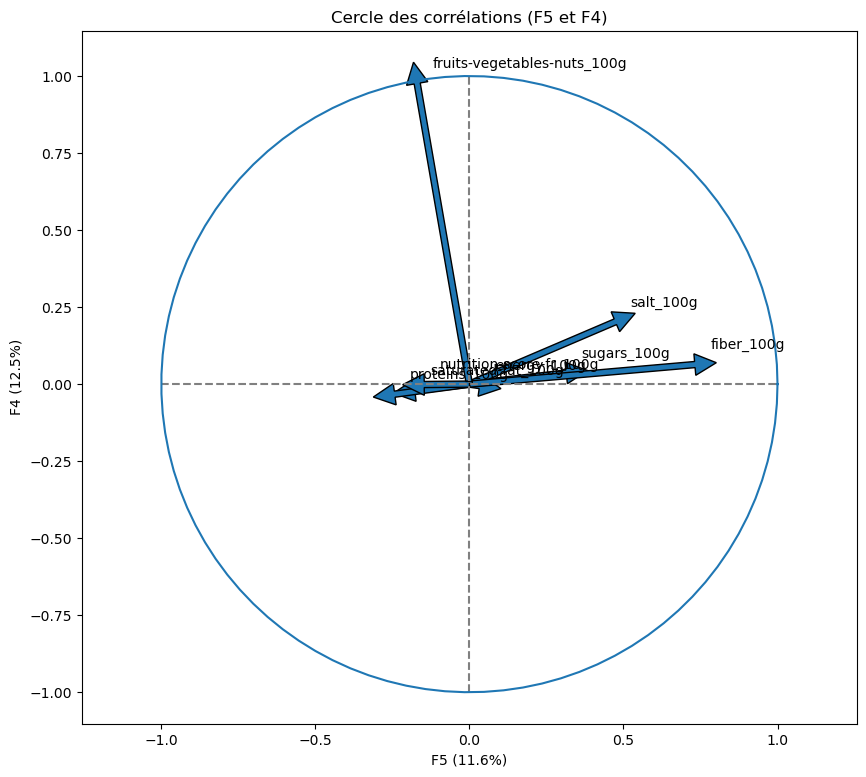

<Figure size 640x480 with 0 Axes>

In [259]:
for i in range(5):
 for j in range(5):
    if (i != j) & (i < j):
        display_factorial_planes(OpenFoodProducts_details_short_filled_proj, (j, i), pca, clusters=OpenFoodProducts_details_short_filled['Nutriscore_Code']) 
        display_factorial_planes(OpenFoodProducts_details_short_filled_proj, (j, i), pca, clusters=OpenFoodProducts_details_short_filled['nutrition-score-fr_100g'])
        correlation_graph(pca, (j,i), features)
        
plt.tight_layout()
plt.show()

Sur les graphes précédents, on pourra étudier la projection des différents produits sur ces nouvelles composantes, un code couleur a été ajouté pour voir comment le code nutriscore se comporte selon les différentes situations et si on arrive à ressortir des clusters. 
J'ai ausssi ajouté un 3ème graphe qui représente le code couleur telle que c'est actuellment traité pour voir si le clustering est respectée telle que c'est représenté aujourdhui.